# <font color='#BFD72F'> The Spies Among Us - Jupyter Notebook </font>

## <font color='#808080'> PMDM - Spring Semester 2021/2022 </font>

###### <font color='#808080'> Developed by Group 03 </font>
 - Afonso Ramalho
 - Francisco Rodrigues
 - Jorge Martins
 - Maria Inês Rézio
 - Rodrigo Correia

### <font color='#BFD72F'>Contents</font><a class="anchor" id="toc"></a>

1. [Importing Data & Libraries](#imports)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#prep)
4. [Feature Selection & Engineeringg](#fe)
5. [Building Models](#models)
6. [Analysing Results](#results)
7. [Testing Models](#tests)

### <font color='#BFD72F'>1. Importing Data & Libraries</font><a class="anchor" id="imports"></a>

In [1]:
# Import libraries and packages
import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

%matplotlib inline

from scipy.stats.mstats import winsorize

from sklearn.impute  import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV, SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import f1_score, accuracy_score, recall_score, \
                            precision_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
                            AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier

In [2]:
# Read datasets files
df = pd.read_csv('data/espionage_data.csv')
X_test = pd.read_csv('data/espionage_data_test.csv')

In [3]:
# Define necessary functions

# Function to check outliers in dataset
def estimate_outliers(dataset):
    
    # Interquartile range
    iqr = dataset.quantile(0.75) - dataset.quantile(0.25)
    
    outliers = dataset[
        ((dataset < (dataset.quantile(0.25) - 1.5 * iqr)) | 
         (dataset > (dataset.quantile(0.75)  + 1.5 * iqr)))]
    
    return outliers

# Clipping outliers using the dataset percentiles
def percentile_capping(df, cols, from_low_end, from_high_end):
    for col in cols:
        winsorize(df[col], limits=(from_low_end, from_high_end), inplace=True)
        
# Clip outliers     
#def clip_outliers(df, columns):
#    for column in columns:
#        iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
#        limit = df[column].quantile(0.75) + 1.5 * iqr
#        df[column][df[column] > df[column].quantile(0.75)] = limit

### <font color='#BFD72F'>2. Exploratory Data Analysis</font><a class="anchor" id="eda"></a>

In [4]:
# Check dataset columns and rows format and values
df.head(10)

,ID,ID_ORIGINAL,Gender,Foreign_Citizenship,Age,Frequent_Traveler,Cellphone_Usage,Household_Size,Spy,Satisfaction_Level,Occupation,Political_Participation,Social_Person,Area_Residence,Military_Service,Household_Income
0,1000,467329,Female,No,40,Yes,Low,1.0,1,4.0,Government,No involvement,No,City,Never,7000
1,1001,461212,Female,No,30,No,Low,6.0,0,1.0,Nothing,No involvement,No,City,Never,19610
2,1002,466216,Male,No,29,No,Low,4.0,0,1.0,Private company,Strong involvement,Yes,Country-side,Never,8261
3,1003,462613,Female,Yes,35,No,Average,5.0,0,1.0,Private company,No involvement,Yes,Country-side,Never,7000
4,1004,465709,Male,Yes,68,Yes,Average,2.0,1,4.0,Private company,Strong involvement,No,City,Never,8261
5,1005,466716,Female,Yes,79,Yes,Low,1.0,1,8.0,Self-employed,No involvement,No,City,Never,8261
6,1006,466512,Female,No,22,No,Low,2.0,0,2.0,Private company,Some involvement,No,City,Never,8261
7,1007,466144,Female,Yes,48,No,Low,NaN,1,NaN,Private company,Unknown,NaN,NaN,NaN,7000
8,1008,466799,Female,No,19,No,Low,3.0,0,1.0,Private company,Some involvement,No,City,Never,9522
9,1009,465043,Male,Yes,48,Yes,Average,5.0,1,1.0,Government,No involvement,No,City,Never,18349


In [5]:
# Set a new index
df.drop('ID', inplace=True, axis=1)
df.set_index('ID_ORIGINAL', inplace=True)

In [6]:
# Check general information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 467329 to 467106
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   8000 non-null   object 
 1   Foreign_Citizenship      7862 non-null   object 
 2   Age                      8000 non-null   int64  
 3   Frequent_Traveler        7923 non-null   object 
 4   Cellphone_Usage          8000 non-null   object 
 5   Household_Size           7670 non-null   float64
 6   Spy                      8000 non-null   int64  
 7   Satisfaction_Level       7670 non-null   float64
 8   Occupation               7876 non-null   object 
 9   Political_Participation  7876 non-null   object 
 10  Social_Person            7924 non-null   object 
 11  Area_Residence           7924 non-null   object 
 12  Military_Service         7924 non-null   object 
 13  Household_Income         8000 non-null   int64  
dtypes: float64(2), in

In [7]:
# Number of rows and columns, respectively
df.shape

(8000, 14)

In [8]:
# Summary statistics of the numerical variables 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8000.0,43.576625,16.704319,18.0,31.0,41.0,53.0,89.0
Household_Size,7670.0,2.844329,1.527431,1.0,2.0,3.0,4.0,9.0
Spy,8000.0,0.477625,0.499530,0.0,0.0,0.0,1.0,1.0
Satisfaction_Level,7670.0,2.641851,1.711686,1.0,1.0,2.0,4.0,9.0
Household_Income,8000.0,9985.575125,4190.830154,7000.0,7000.0,8261.0,12044.0,24654.0


In [9]:
# Summary statistics of the categorical variables 
df.describe(include=['O']).T

,count,unique,top,freq
Gender,8000,2,Male,4392
Foreign_Citizenship,7862,2,Yes,4632
Frequent_Traveler,7923,2,Yes,4938
Cellphone_Usage,8000,3,Low,4815
Occupation,7876,6,Private company,5444
Political_Participation,7876,4,No involvement,3125
Social_Person,7924,2,No,5211
Area_Residence,7924,2,City,6838
Military_Service,7924,4,Never,7537


In [10]:
df._get_numeric_data().var()

Age                   2.790343e+02
Household_Size        2.333046e+00
Spy                   2.495306e-01
Satisfaction_Level    2.929869e+00
Household_Income      1.756306e+07
dtype: float64

In [11]:
df['Spy'].value_counts(normalize=True)

0    0.522375
1    0.477625
Name: Spy, dtype: float64

In [12]:
pd.crosstab(df["Foreign_Citizenship"], df["Frequent_Traveler"])

Frequent_Traveler,No,Yes
Foreign_Citizenship,,
No,1558,1642
Yes,1359,3230


<AxesSubplot:xlabel='Frequent_Traveler', ylabel='count'>

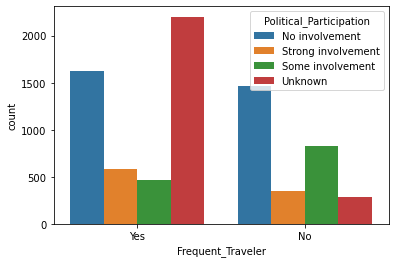

In [13]:
sns.countplot(x="Frequent_Traveler", hue="Political_Participation", data=df)

###### Split dataset into train & validation data

In [14]:
data = df.drop('Spy', axis=1)
target = df['Spy']

X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, stratify=target, random_state=5, shuffle=True)

### <font color='#BFD72F'>3. Data Preprocessing</font><a class="anchor" id="prep"></a>

In [15]:
# Overview of the dataset
X_train.head(10)

,Gender,Foreign_Citizenship,Age,Frequent_Traveler,Cellphone_Usage,Household_Size,Satisfaction_Level,Occupation,Political_Participation,Social_Person,Area_Residence,Military_Service,Household_Income
ID_ORIGINAL,,,,,,,,,,,,,
465080,Male,Yes,70,Yes,Average,2.0,4.0,Self-employed,No involvement,No,City,Never,17088
462698,Female,Yes,56,Yes,Average,2.0,3.0,Private company,Strong involvement,No,City,Never,8261
465477,Male,No,31,No,Low,3.0,2.0,Private company,Some involvement,Yes,City,Never,8261
459236,Female,Yes,86,No,High,2.0,5.0,Self-employed,No involvement,No,City,Never,7000
464465,Female,Yes,37,Yes,Average,6.0,1.0,Private company,Unknown,Yes,City,Never,7000
463943,Male,No,71,Yes,Low,2.0,4.0,Private company,Strong involvement,No,City,Never,8261
463321,Male,No,22,No,Low,3.0,1.0,Private company,Some involvement,Yes,City,Intervention in Syria,8261
467753,Female,Yes,69,No,High,2.0,4.0,Private company,Unknown,No,City,Never,7000
462379,Female,Yes,60,Yes,Average,3.0,2.0,Private company,Unknown,No,City,Never,8261


In [16]:
# Check for missing values
X_train.isna().sum()

Gender                       0
Foreign_Citizenship        110
Age                          0
Frequent_Traveler           59
Cellphone_Usage              0
Household_Size             265
Satisfaction_Level         265
Occupation                  94
Political_Participation     94
Social_Person               59
Area_Residence              59
Military_Service            59
Household_Income             0
dtype: int64

In [17]:
#Percentage of missing values by feature
for col in X_train:
    print(f'Column {col}: {X_train[col].isnull().sum()} Missing values --> {round(X_train[col].isnull().sum() / len(X_train) * 100, 2)} %')

Column Gender: 0 Missing values --> 0.0 %
Column Foreign_Citizenship: 110 Missing values --> 1.72 %
Column Age: 0 Missing values --> 0.0 %
Column Frequent_Traveler: 59 Missing values --> 0.92 %
Column Cellphone_Usage: 0 Missing values --> 0.0 %
Column Household_Size: 265 Missing values --> 4.14 %
Column Satisfaction_Level: 265 Missing values --> 4.14 %
Column Occupation: 94 Missing values --> 1.47 %
Column Political_Participation: 94 Missing values --> 1.47 %
Column Social_Person: 59 Missing values --> 0.92 %
Column Area_Residence: 59 Missing values --> 0.92 %
Column Military_Service: 59 Missing values --> 0.92 %
Column Household_Income: 0 Missing values --> 0.0 %


Missing values are present in both numerical and categorical columns like 'Household_Size' (numerical) or 'Frequent_Traveler' (categorical)

In [18]:
# Check duplicates
X_train[X_train.index.duplicated(keep=False)]

,Gender,Foreign_Citizenship,Age,Frequent_Traveler,Cellphone_Usage,Household_Size,Satisfaction_Level,Occupation,Political_Participation,Social_Person,Area_Residence,Military_Service,Household_Income
ID_ORIGINAL,,,,,,,,,,,,,


There are no duplicates in the dataset

In [19]:
# Get the numerical columns into a DF
num_df = X_train._get_numeric_data()

# Get the categorical columns into a DF
cat_df = X_train.select_dtypes(exclude='number')

In [20]:
# Get the numerical columns into a list
num_cols = num_df.columns.tolist()

# Get the categorical columns into a list
cat_cols = cat_df.columns.tolist()

In [21]:
num_df.head()

,Age,Household_Size,Satisfaction_Level,Household_Income
ID_ORIGINAL,,,,
465080,70,2.0,4.0,17088
462698,56,2.0,3.0,8261
465477,31,3.0,2.0,8261
459236,86,2.0,5.0,7000
464465,37,6.0,1.0,7000


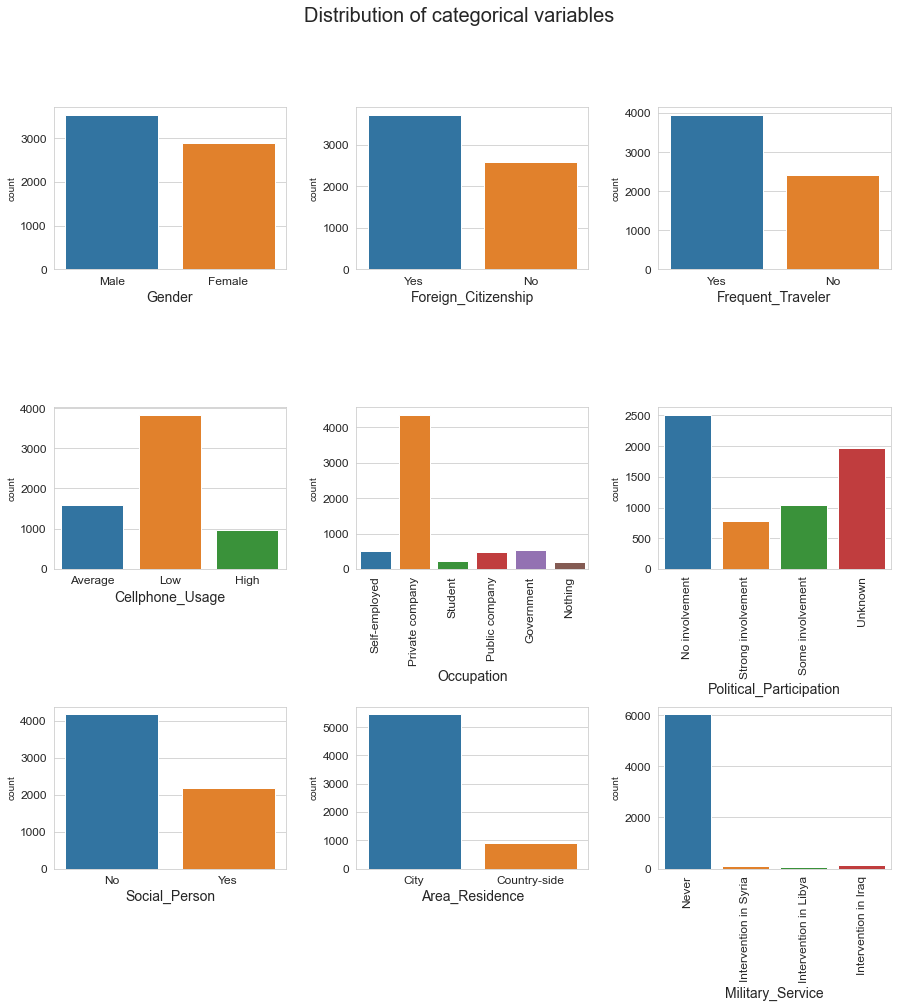

In [22]:
import warnings
warnings.simplefilter("ignore")

# Barplots for categorical variables
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,14))

ax1 = sns.countplot(cat_df["Gender"], ax=axes[0,0])
ax2 = sns.countplot(cat_df["Foreign_Citizenship"], ax=axes[0,1])
ax3 = sns.countplot(cat_df["Frequent_Traveler"], ax=axes[0,2])
ax4 = sns.countplot(cat_df["Cellphone_Usage"], ax=axes[1,0])
ax5 = sns.countplot(cat_df["Occupation"], ax=axes[1,1])
ax6 = sns.countplot(cat_df["Political_Participation"], ax=axes[1,2])
ax7 = sns.countplot(cat_df["Social_Person"], ax=axes[2,0])
ax8 = sns.countplot(cat_df["Area_Residence"], ax=axes[2,1])
ax9 = sns.countplot(cat_df["Military_Service"], ax=axes[2,2])

ax1.tick_params(labelsize=12)
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.set_xlabel(xlabel='Gender',fontsize = 14)

ax2.tick_params(labelsize=12)
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.set_xlabel(xlabel='Foreign_Citizenship',fontsize = 14)

ax3.tick_params(labelsize=12)
ax3.set_xticklabels(ax3.get_xticklabels())
ax3.set_xlabel(xlabel='Frequent_Traveler',fontsize = 14)

ax4.tick_params(labelsize=12)
ax4.set_xticklabels(ax4.get_xticklabels())
ax4.set_xlabel(xlabel='Cellphone_Usage',fontsize = 14)

ax5.tick_params(labelsize=12)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
ax5.set_xlabel(xlabel='Occupation',fontsize = 14)

ax6.tick_params(labelsize=12)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=90)
ax6.set_xlabel(xlabel='Political_Participation',fontsize = 14)

ax7.tick_params(labelsize=12)
ax7.set_xticklabels(ax7.get_xticklabels())
ax7.set_xlabel(xlabel='Social_Person',fontsize = 14)

ax8.tick_params(labelsize=12)
ax8.set_xticklabels(ax8.get_xticklabels())
ax8.set_xlabel(xlabel='Area_Residence',fontsize = 14)

ax9.tick_params(labelsize=12)
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=90)
ax9.set_xlabel(xlabel='Military_Service',fontsize = 14)

plt.suptitle('Distribution of categorical variables', fontsize=20)
plt.subplots_adjust(hspace=0.85, wspace=0.30)
plt.show()

It's possible to observe that no duplicates were found in the dataset

In [23]:
# Create new dataset without the categorical columns for train & validation data
num_train = X_train[num_cols]
num_val = X_val[num_cols]

In [24]:
# Check for missing values
num_train.isna().sum()

Age                     0
Household_Size        265
Satisfaction_Level    265
Household_Income        0
dtype: int64

In [25]:
# Check for missing values
num_val.isna().sum()

Age                    0
Household_Size        65
Satisfaction_Level    65
Household_Income       0
dtype: int64

In [26]:
# Create the imputer
imputer = KNNImputer()

# Fit & Transform the dataset using KNN Imputation
num_train = pd.DataFrame(
    imputer.fit_transform(num_train),
    columns=num_train.columns,
    index=num_train.index)

num_val = pd.DataFrame(
    imputer.transform(num_val),
    columns=num_val.columns,
    index=num_val.index)

In [27]:
# Check for missing values
num_train.isna().sum()

Age                   0
Household_Size        0
Satisfaction_Level    0
Household_Income      0
dtype: int64

In [28]:
# Check for missing values
num_val.isna().sum()

Age                   0
Household_Size        0
Satisfaction_Level    0
Household_Income      0
dtype: int64

In [29]:
X_train.loc[:, ['Household_Size', 'Satisfaction_Level']] = num_train[['Household_Size', 'Satisfaction_Level']]
X_val.loc[:, ['Household_Size', 'Satisfaction_Level']] = num_val[['Household_Size', 'Satisfaction_Level']]

In [30]:
# Check for missing values
X_train_before = X_train.copy()
X_train.isna().sum()

Gender                       0
Foreign_Citizenship        110
Age                          0
Frequent_Traveler           59
Cellphone_Usage              0
Household_Size               0
Satisfaction_Level           0
Occupation                  94
Political_Participation     94
Social_Person               59
Area_Residence              59
Military_Service            59
Household_Income             0
dtype: int64

In [31]:
# Check for missing values
X_val_before = X_val.copy()
X_val.isna().sum()

Gender                      0
Foreign_Citizenship        28
Age                         0
Frequent_Traveler          18
Cellphone_Usage             0
Household_Size              0
Satisfaction_Level          0
Occupation                 30
Political_Participation    30
Social_Person              17
Area_Residence             17
Military_Service           17
Household_Income            0
dtype: int64

In [32]:
# Fill the missing values in categorical features using the most frequent value
X_train[cat_cols] = X_train[cat_cols].fillna(X_train.mode().iloc[0])
X_val[cat_cols] = X_val[cat_cols].fillna(X_val.mode().iloc[0])

In [33]:
# Check for missing values
X_train.isna().sum()

Gender                     0
Foreign_Citizenship        0
Age                        0
Frequent_Traveler          0
Cellphone_Usage            0
Household_Size             0
Satisfaction_Level         0
Occupation                 0
Political_Participation    0
Social_Person              0
Area_Residence             0
Military_Service           0
Household_Income           0
dtype: int64

In [34]:
# Check for missing values
X_val.isna().sum()

Gender                     0
Foreign_Citizenship        0
Age                        0
Frequent_Traveler          0
Cellphone_Usage            0
Household_Size             0
Satisfaction_Level         0
Occupation                 0
Political_Participation    0
Social_Person              0
Area_Residence             0
Military_Service           0
Household_Income           0
dtype: int64

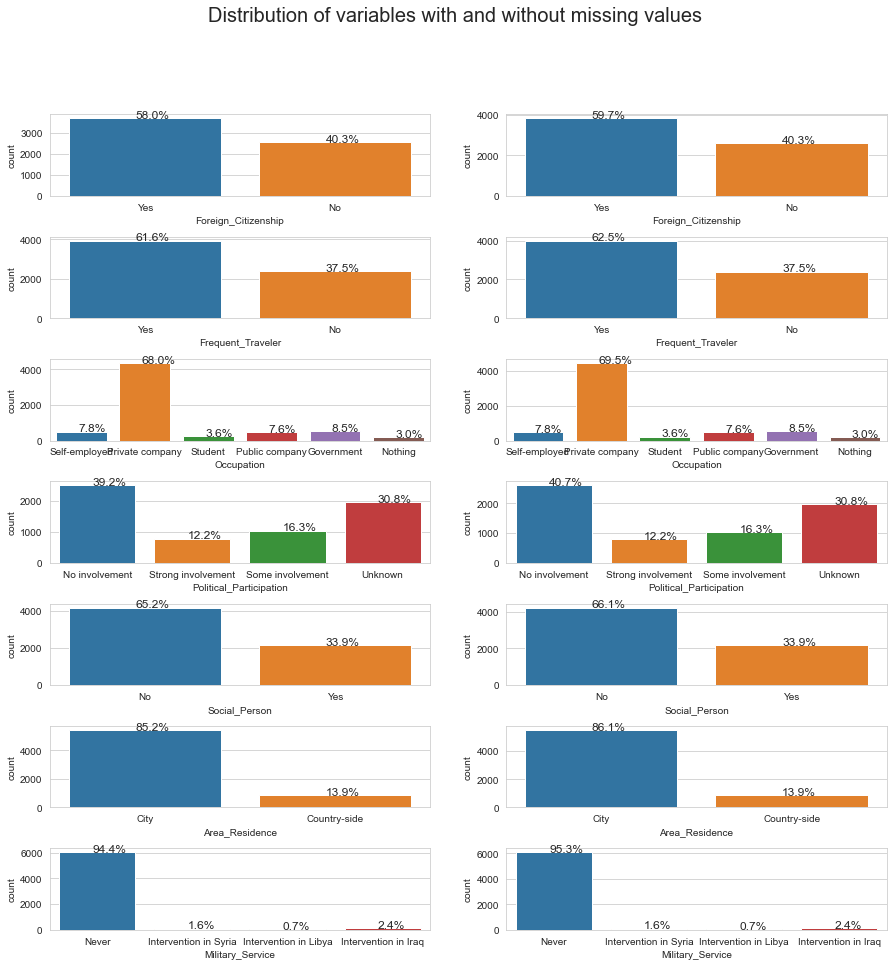

In [35]:
# Plot categorical variables distribution before and after the imputation of missing values
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)


sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,15))

ax2 = sns.countplot(X_train_before["Foreign_Citizenship"], ax=axes[0,0])
without_hue(ax2, X_train_before["Foreign_Citizenship"])  
ay2 = sns.countplot(X_train["Foreign_Citizenship"], ax=axes[0,1])
without_hue(ay2, X_train["Foreign_Citizenship"])  

ax3 = sns.countplot(X_train_before["Frequent_Traveler"], ax=axes[1,0])
without_hue(ax3, X_train_before["Frequent_Traveler"])  
ay3 = sns.countplot(X_train["Frequent_Traveler"], ax=axes[1,1])
without_hue(ay3, X_train["Frequent_Traveler"])  

ax5 = sns.countplot(X_train_before["Occupation"], ax=axes[2,0])
without_hue(ax5, X_train_before["Occupation"])  
ay5 = sns.countplot(X_train["Occupation"], ax=axes[2,1])
without_hue(ay5, X_train["Occupation"])

ax6 = sns.countplot(X_train_before["Political_Participation"], ax=axes[3,0])
without_hue(ax6, X_train_before["Political_Participation"])  
ay6 = sns.countplot(X_train["Political_Participation"], ax=axes[3,1])
without_hue(ay6, X_train["Political_Participation"])  

ax7 = sns.countplot(X_train_before["Social_Person"], ax=axes[4,0])
without_hue(ax7, X_train_before["Social_Person"])  
ay7 = sns.countplot(X_train["Social_Person"], ax=axes[4,1])
without_hue(ay7, X_train["Social_Person"])  

ax8 = sns.countplot(X_train_before["Area_Residence"], ax=axes[5,0])
without_hue(ax8, X_train_before["Area_Residence"])  
ay8 = sns.countplot(X_train["Area_Residence"], ax=axes[5,1])
without_hue(ay8, X_train["Area_Residence"])  

ax9 = sns.countplot(X_train_before["Military_Service"], ax=axes[6,0])
without_hue(ax9, X_train_before["Military_Service"])  
ay9 = sns.countplot(X_train["Military_Service"], ax=axes[6,1])
without_hue(ay9, X_train["Military_Service"])  

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.suptitle('Distribution of variables with and without missing values', fontsize=20)
plt.show()

Text(0.5, 0.98, 'Distribution of variables with and without missing values in Validation Data')

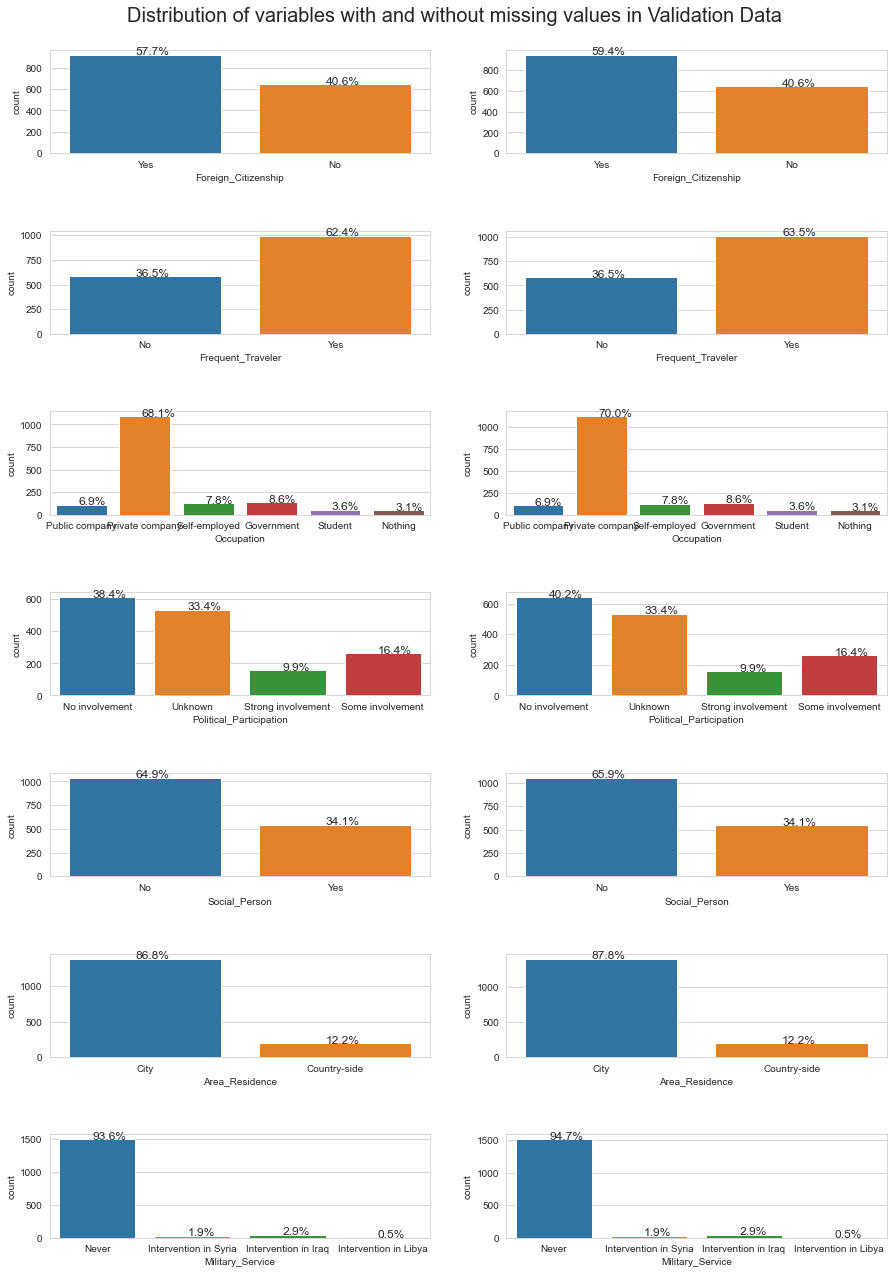

In [36]:
# Plot categorical varibles distribution before and after imputation of missing values
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)


sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20))

ax2 = sns.countplot(X_val_before["Foreign_Citizenship"], ax=axes[0,0])
without_hue(ax2, X_val_before["Foreign_Citizenship"])  
ay2 = sns.countplot(X_val["Foreign_Citizenship"], ax=axes[0,1])
without_hue(ay2, X_val["Foreign_Citizenship"])  

ax3 = sns.countplot(X_val_before["Frequent_Traveler"], ax=axes[1,0])
without_hue(ax3, X_val_before["Frequent_Traveler"])  
ay3 = sns.countplot(X_val["Frequent_Traveler"], ax=axes[1,1])
without_hue(ay3, X_val["Frequent_Traveler"])  

ax5 = sns.countplot(X_val_before["Occupation"], ax=axes[2,0])
without_hue(ax5, X_val_before["Occupation"])  
ay5 = sns.countplot(X_val["Occupation"], ax=axes[2,1])
without_hue(ay5, X_val["Occupation"])  

ax6 = sns.countplot(X_val_before["Political_Participation"], ax=axes[3,0])
without_hue(ax6, X_val_before["Political_Participation"])  
ay6 = sns.countplot(X_val["Political_Participation"], ax=axes[3,1])
without_hue(ay6, X_val["Political_Participation"])  

ax7 = sns.countplot(X_val_before["Social_Person"], ax=axes[4,0])
without_hue(ax7, X_val_before["Social_Person"])  
ay7 = sns.countplot(X_val["Social_Person"], ax=axes[4,1])
without_hue(ay7, X_val["Social_Person"])  

ax8 = sns.countplot(X_val_before["Area_Residence"], ax=axes[5,0])
without_hue(ax8, X_val_before["Area_Residence"])  
ay8 = sns.countplot(X_val["Area_Residence"], ax=axes[5,1])
without_hue(ay8, X_val["Area_Residence"])  

ax9 = sns.countplot(X_val_before["Military_Service"], ax=axes[6,0])
without_hue(ax9, X_val_before["Military_Service"])  
ay9 = sns.countplot(X_val["Military_Service"], ax=axes[6,1])
without_hue(ay9, X_val["Military_Service"])  

plt.subplots_adjust(top=0.95,hspace=0.75)
plt.suptitle("Distribution of variables with and without missing values in Validation Data", fontsize=20)

In [37]:
# Get dummies for the categorical features
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=True)

In [38]:
X_train.columns

Index(['Age', 'Household_Size', 'Satisfaction_Level', 'Household_Income',
       'Gender_Male', 'Foreign_Citizenship_Yes', 'Frequent_Traveler_Yes',
       'Cellphone_Usage_High', 'Cellphone_Usage_Low', 'Occupation_Nothing',
       'Occupation_Private company', 'Occupation_Public company',
       'Occupation_Self-employed', 'Occupation_Student',
       'Political_Participation_Some involvement',
       'Political_Participation_Strong involvement',
       'Political_Participation_Unknown', 'Social_Person_Yes',
       'Area_Residence_Country-side', 'Military_Service_Intervention in Libya',
       'Military_Service_Intervention in Syria', 'Military_Service_Never'],
      dtype='object')

###### 

<AxesSubplot:title={'center':'Correlation with Target\n'}>

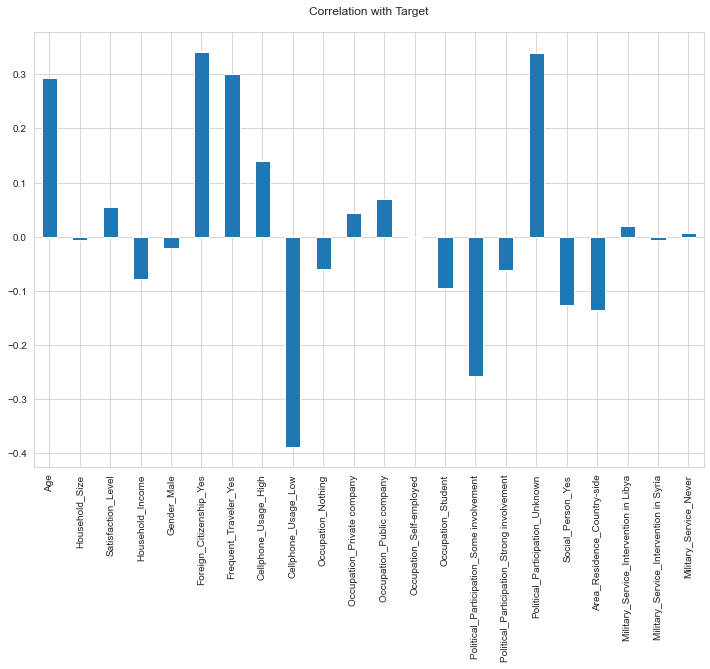

In [39]:
X_train.corrwith(df.Spy).plot.bar(figsize=(12, 8), title='Correlation with Target\n', fontsize=10)

In [40]:
# Outliers for all columns
print('\033[1m' + 'Training Outliers\n'+ '\033[0m')

for column in num_cols[1:]:
    outliers = estimate_outliers(X_train[column])
    
    print(f'Outliers in {column}:')
    print('Number of outliers: '+ str(len(outliers)))
    print('Max outlier value: '+ str(outliers.max()))
    print('Min outlier value: '+ str(outliers.min()))
    print('\n')

Training Outliers

Outliers in Household_Size:
Number of outliers: 74
Max outlier value: 9.0
Min outlier value: 8.0


Outliers in Satisfaction_Level:
Number of outliers: 146
Max outlier value: 9.0
Min outlier value: 8.0


Outliers in Household_Income:
Number of outliers: 154
Max outlier value: 24654
Min outlier value: 20871




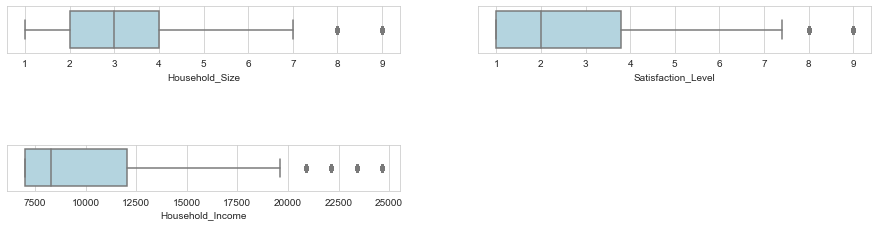

In [41]:
for i in range(1, len(num_cols[1:])+1):
    plt.subplot(9, 2, i)
    sns.boxplot(x=X_train[num_cols[i]], data=X_train[num_cols[i]], color='lightblue')
    
plt.subplots_adjust(top=5, bottom=1, left=1, right=3, hspace=2)
plt.show()

In [42]:
#clip_outliers(X_train, ['Household_Size', 'Household_Income', 'Satisfaction_Level'])

In [43]:
percentile_capping(X_train, ['Household_Size'], 0, 0.02)
percentile_capping(X_train, ['Household_Income', 'Satisfaction_Level'], 0, 0.03)

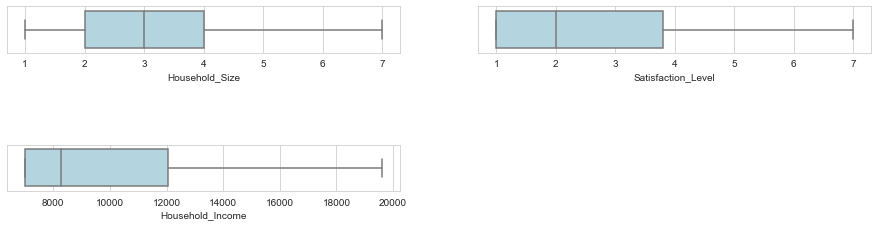

In [44]:
for i in range(1, len(num_cols[1:])+1):
    plt.subplot(9, 2, i)
    sns.boxplot(x=X_train[num_cols[i]], data=X_train[num_cols[i]], color='lightblue')
    
plt.subplots_adjust(top=5, bottom=1, left=1, right=3, hspace=2)
plt.show()

In [45]:
# Outliers for all columns
print('\033[1m' + 'Validation Outliers\n' + '\033[0m')

for column in num_cols[1:]:
    outliers = estimate_outliers(X_val[column])
    
    print(f'Outliers in {column}')
    print('Number of outliers: '+ str(len(outliers)))
    print('Max outlier value: '+ str(outliers.max()))
    print('Min outlier value: '+ str(outliers.min()))
    print('\n')

Validation Outliers

Outliers in Household_Size
Number of outliers: 17
Max outlier value: 9.0
Min outlier value: 8.0


Outliers in Satisfaction_Level
Number of outliers: 72
Max outlier value: 9.0
Min outlier value: 6.4


Outliers in Household_Income
Number of outliers: 224
Max outlier value: 24654
Min outlier value: 17088




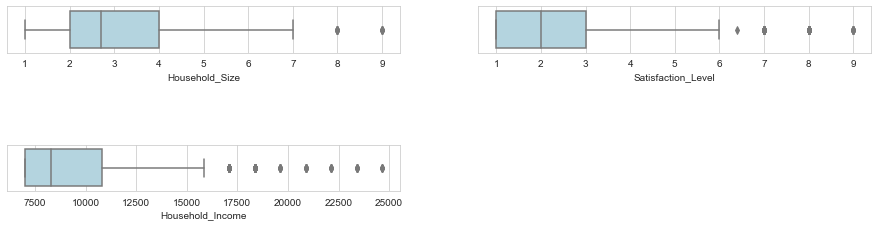

In [46]:
for i in range(1, len(num_cols[1:])+1):
    plt.subplot(9, 2, i)
    sns.boxplot(x=X_val[num_cols[i]], data=X_val[num_cols[i]], color='lightblue')
    
plt.subplots_adjust(top=5, bottom=1, left=1, right=3, hspace=2)
plt.show()

In [47]:
#clip_outliers(X_val, ['Household_Size', 'Household_Income', 'Satisfaction_Level'])

In [48]:
percentile_capping(X_val, ['Household_Size'], 0, 0.02)
percentile_capping(X_val, ['Household_Income', 'Satisfaction_Level'], 0, 0.03)

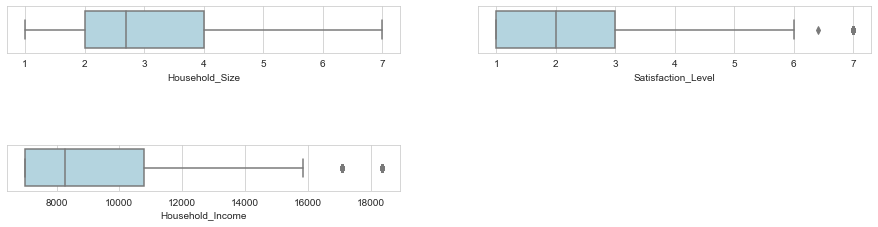

In [49]:
for i in range(1, len(num_cols[1:])+1):
    plt.subplot(9, 2, i)
    sns.boxplot(x=X_val[num_cols[i]], data=X_val[num_cols[i]], color='lightblue')
    
plt.subplots_adjust(top=5, bottom=1, left=1, right=3, hspace=2)
plt.show()

<Figure size 864x720 with 0 Axes>

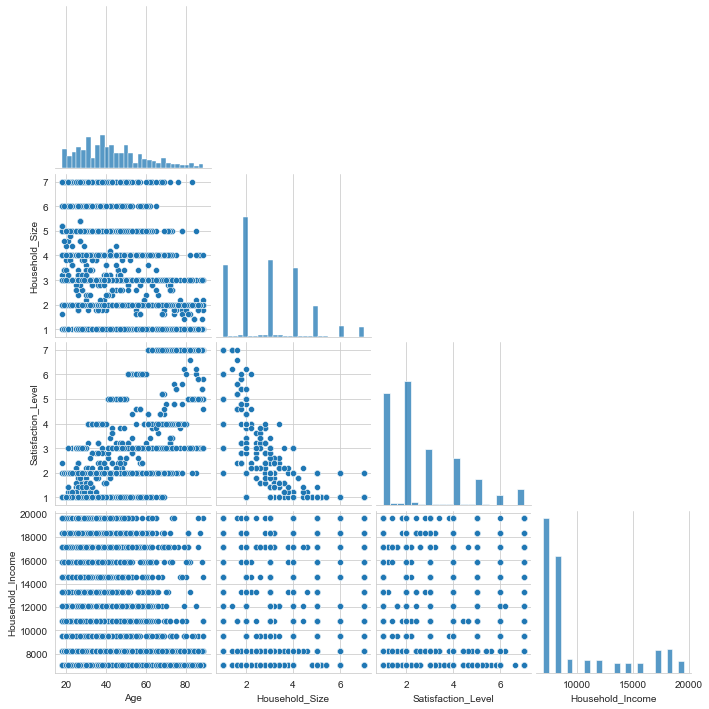

In [50]:
# Pair plot for the numerical features
plt.figure(figsize=(12,10))
sns.pairplot(X_train[num_cols], corner=True)

plt.show()

It's possible to observe that some variables have a relationship, like 'Satisfaction_Level' and 'Household_Size'

In [51]:
#Spearman correlations
spearman = X_train.corr(method='spearman')

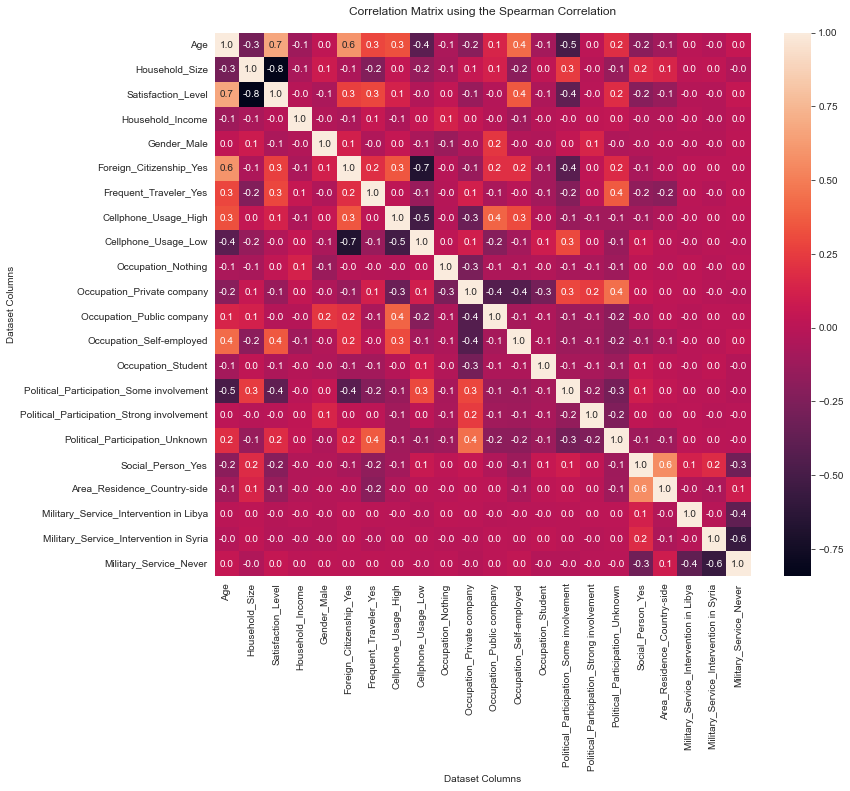

In [52]:
plt.figure(figsize=(12,10))

hm_spearman = sns.heatmap(spearman, annot=True, fmt = '.1f')
hm_spearman.set(
    xlabel = 'Dataset Columns',
    ylabel = 'Dataset Columns',
    title = 'Correlation Matrix using the Spearman Correlation\n')

plt.show()

We can observe highly correlacted variables, like 'Satisfaction_Level' and 'Household_Size'.

In the next step, where we will be doing feature selection, we will try to choose the features based on the their feature importance, but also in the correlaction between variables.

In [53]:
X_train.agg(['skew','kurtosis']).T

,skew,kurtosis
Age,0.691057,-0.164661
Household_Size,0.756037,0.141871
Satisfaction_Level,1.080276,0.527945
Household_Income,1.282614,0.115977
Gender_Male,-0.201689,-1.959934
Foreign_Citizenship_Yes,-0.394415,-1.845013
Frequent_Traveler_Yes,-0.515830,-1.734461
Cellphone_Usage_High,1.937036,1.752654
Cellphone_Usage_Low,-0.403031,-1.838140
Occupation_Nothing,5.480422,28.043793


### <font color='#BFD72F'>4. Feature Selection & Engineering</font><a class="anchor" id="fe"></a>

In [54]:
# Overview of the training data
X_train

,Age,Household_Size,Satisfaction_Level,Household_Income,Gender_Male,Foreign_Citizenship_Yes,Frequent_Traveler_Yes,Cellphone_Usage_High,Cellphone_Usage_Low,Occupation_Nothing,...,Occupation_Self-employed,Occupation_Student,Political_Participation_Some involvement,Political_Participation_Strong involvement,Political_Participation_Unknown,Social_Person_Yes,Area_Residence_Country-side,Military_Service_Intervention in Libya,Military_Service_Intervention in Syria,Military_Service_Never
ID_ORIGINAL,,,,,,,,,,,,,,,,,,,,,
465080,70,2.0,4.0,17088,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
462698,56,2.0,3.0,8261,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
465477,31,3.0,2.0,8261,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
459236,86,2.0,5.0,7000,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
464465,37,6.0,1.0,7000,0,1,1,0,0,0,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465964,47,1.0,5.0,9522,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
459670,39,2.0,2.0,15827,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
461580,38,7.0,1.0,15827,0,0,1,0,1,0,...,0,0,0,0,1,1,0,0,0,1


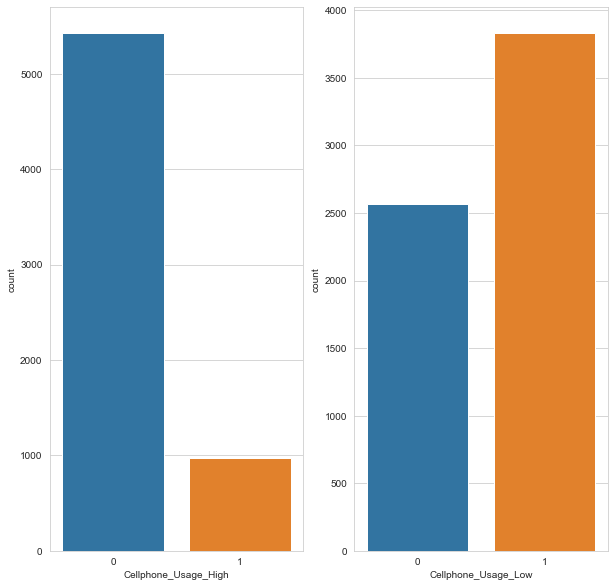

In [55]:
# Working with Cellphone_Usage_High and Cellphone_Usage_Low
fig, ax = plt.subplots(1,2, figsize=(10,10))

sns.countplot(X_train['Cellphone_Usage_High'], ax=ax[0])
sns.countplot(X_train['Cellphone_Usage_Low'], ax=ax[1])

fig.show()

# Trying to understand if Cellphone_Usage_High has a inverse relation with Cellphone_Usage_Low

In [56]:
# Feature Scaling
minmax = MinMaxScaler()

# Fit & Transform the datasets using MinMaxScaler
X_train = pd.DataFrame(
    minmax.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index)

X_val = pd.DataFrame(
    minmax.transform(X_val),
    columns=X_train.columns,
    index=X_val.index)

In [57]:
# Overview of the training data normalized
X_train

,Age,Household_Size,Satisfaction_Level,Household_Income,Gender_Male,Foreign_Citizenship_Yes,Frequent_Traveler_Yes,Cellphone_Usage_High,Cellphone_Usage_Low,Occupation_Nothing,...,Occupation_Self-employed,Occupation_Student,Political_Participation_Some involvement,Political_Participation_Strong involvement,Political_Participation_Unknown,Social_Person_Yes,Area_Residence_Country-side,Military_Service_Intervention in Libya,Military_Service_Intervention in Syria,Military_Service_Never
ID_ORIGINAL,,,,,,,,,,,,,,,,,,,,,
465080,0.732394,0.166667,0.500000,0.8,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
462698,0.535211,0.166667,0.333333,0.1,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
465477,0.183099,0.333333,0.166667,0.1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
459236,0.957746,0.166667,0.666667,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
464465,0.267606,0.833333,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465964,0.408451,0.000000,0.666667,0.2,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
459670,0.295775,0.166667,0.166667,0.7,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
461580,0.281690,1.000000,0.000000,0.7,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [58]:
print(f'Number of features: {X_train.shape[1]}')

Number of features: 22


In [59]:
# Model building
log_reg = LogisticRegressionCV(cv=5, random_state=5).fit(X_train, y_train)

In [60]:
# Score for training data
log_reg.score(X_train, y_train)

0.746875

In [61]:
# Score for validation data
log_reg.score(X_val, y_val)

0.746875

In [62]:
# F1 score for training data
f1_score(y_train, log_reg.predict(X_train))

0.7345132743362832

In [63]:
# F1 score for validation data
f1_score(y_val, log_reg.predict(X_val))

0.7326732673267328

In [64]:
log_reg_importance = log_reg.coef_[0]

log_reg_importance_df = pd.DataFrame(
    log_reg_importance,
    columns=['Logistic Regression'],
    index=X_train.columns.tolist()
)

<AxesSubplot:>

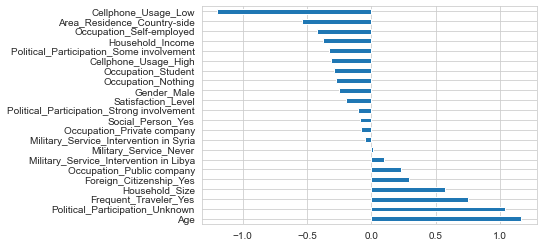

In [65]:
log_reg_importance_df['Logistic Regression'].nlargest(22).plot(kind='barh')

In [66]:
# Model building
random_forest = RandomForestClassifier(max_depth=7, random_state=5).fit(X_train, y_train)

In [67]:
# Score for training data
random_forest.score(X_train, y_train)

0.77421875

In [68]:
# Score for validation data
random_forest.score(X_val, y_val)

0.76125

In [69]:
# F1 score for training data
f1_score(y_train, random_forest.predict(X_train))

0.7584823667056659

In [70]:
# F1 score for validation data
f1_score(y_val, random_forest.predict(X_val))

0.7436241610738257

In [71]:
random_forest_importance = random_forest.feature_importances_

random_forest_importance_df = pd.DataFrame(
    random_forest_importance,
    columns=['Random Forest'],
    index=X_train.columns.tolist()
)

<AxesSubplot:>

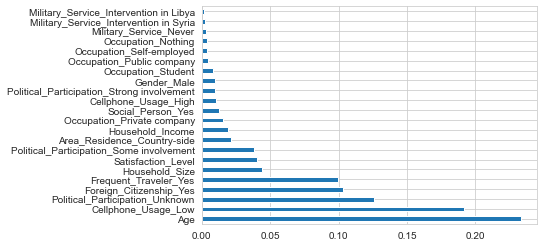

In [72]:
random_forest_importance_df['Random Forest'].nlargest(22).plot(kind='barh')

In [73]:
importances_df = random_forest_importance_df.join(log_reg_importance_df)
importances_df.sort_values(by='Logistic Regression', ascending=False)

,Random Forest,Logistic Regression
Age,0.233143,1.166556
Political_Participation_Unknown,0.125996,1.036971
Frequent_Traveler_Yes,0.099227,0.750325
Household_Size,0.043866,0.574879
Foreign_Citizenship_Yes,0.103369,0.295735
Occupation_Public company,0.004531,0.233206
Military_Service_Intervention in Libya,0.001333,0.096251
Military_Service_Never,0.003257,0.016363
Military_Service_Intervention in Syria,0.002607,-0.049696
Occupation_Private company,0.015158,-0.078132


In [74]:
# Feature Elimination using RFE with Cross-validation (Logistic Regression)
rfe_lr = RFECV(estimator=log_reg, cv=5).fit(X_train, y_train)

In [75]:
# Feature Elimination using RFE with Cross-validation (Random Forest)
rfe_rf = RFECV(estimator=random_forest, cv=5).fit(X_train, y_train)

In [76]:
rfe_lr_features = {'Support': rfe_lr.support_, 'Rank': rfe_lr.ranking_}

selected_features_lr = pd.DataFrame(rfe_lr_features, index = X_train.columns)
selected_features_lr[selected_features_lr.Support == True]

,Support,Rank
Age,True,1
Household_Size,True,1
Household_Income,True,1
Gender_Male,True,1
Frequent_Traveler_Yes,True,1
Cellphone_Usage_High,True,1
Cellphone_Usage_Low,True,1
Occupation_Public company,True,1
Occupation_Self-employed,True,1
Political_Participation_Unknown,True,1


In [77]:
rfe_rf_features = {'Support': rfe_rf.support_, 'Rank': rfe_rf.ranking_}

selected_features_rf = pd.DataFrame(rfe_rf_features, index = X_train.columns)
selected_features_rf[selected_features_rf.Support == True]

,Support,Rank
Age,True,1
Household_Size,True,1
Satisfaction_Level,True,1
Household_Income,True,1
Gender_Male,True,1
Foreign_Citizenship_Yes,True,1
Frequent_Traveler_Yes,True,1
Cellphone_Usage_High,True,1
Cellphone_Usage_Low,True,1
Occupation_Private company,True,1


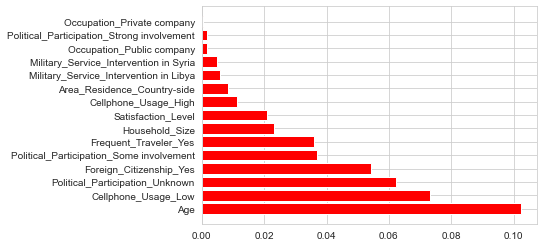

In [78]:
k_best = SelectKBest(mutual_info_classif, k=15).fit(X_train, y_train)

# Get the indices sorted by most important to least important
indices = np.argsort(k_best.scores_)[::-1]

# To get your Top 10 features
features = []
for i in range(15):
    features.append(X_train.columns[indices[i]])

# Plot Top 10 features
plt.figure()
plt.barh(features, k_best.scores_[indices[range(15)]], color='r', align='center')

plt.show()

Correlactions:
- Satisfaction_Level - Household_Size: -0.8
- Satisfaction_Level - Age: 0.7
- Foreign_Citizenship_Yes - Cellphone_Usage_low: -0.7

Since, based on the features selected by the RFE with the RandomForest as well as the one with LogisticRegression, and keeping in mind the correlactions between variables. the selected features will be:

***Age, Household_Size, Household_Income, Gender_Male, Frequent_Traveler_Yes, Cellphone_Usage_High, Cellphone_Usage_Low, Occupation_Public company, Political_Participation_Some involvement, Political_Participation_Unknown, Area_Residence_Country-side***

In [79]:
final_selected_features = selected_features_rf[selected_features_rf.Support == True].index.tolist()

In [80]:
# Transform the training & validation datasets to include only the selected features
#X_train = pd.DataFrame(
#    X_train[final_selected_features],
#    columns=final_selected_features,
#    index=X_train.index)
#
#X_val = pd.DataFrame(
#    X_val[final_selected_features],
#    columns=final_selected_features,
#    index=X_val.index)

X_train = pd.DataFrame(
    rfe_rf.transform(X_train),
    columns=final_selected_features,
    index=X_train.index)

X_val = pd.DataFrame(
    rfe_rf.transform(X_val),
    columns=final_selected_features,
    index=X_val.index)

In [81]:
print(f'Number of features: {X_train.shape[1]}')

Number of features: 16


In [82]:
X_train

,Age,Household_Size,Satisfaction_Level,Household_Income,Gender_Male,Foreign_Citizenship_Yes,Frequent_Traveler_Yes,Cellphone_Usage_High,Cellphone_Usage_Low,Occupation_Private company,Occupation_Student,Political_Participation_Some involvement,Political_Participation_Strong involvement,Political_Participation_Unknown,Social_Person_Yes,Area_Residence_Country-side
ID_ORIGINAL,,,,,,,,,,,,,,,,
465080,0.732394,0.166667,0.500000,0.8,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
462698,0.535211,0.166667,0.333333,0.1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
465477,0.183099,0.333333,0.166667,0.1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
459236,0.957746,0.166667,0.666667,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464465,0.267606,0.833333,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465964,0.408451,0.000000,0.666667,0.2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
459670,0.295775,0.166667,0.166667,0.7,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
461580,0.281690,1.000000,0.000000,0.7,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


...

### <font color='#BFD72F'>5. Building Models</font><a class="anchor" id="models"></a>

###### Gaussian Naive Bayes

In [83]:
modelGaussian = GaussianNB()

In [84]:
modelGaussian.fit(X_train, y_train)

GaussianNB()

In [85]:
# Score for train dataset
modelGaussian.score(X_train, y_train)

0.72234375

In [86]:
# Score for validation data
modelGaussian.score(X_val, y_val)

0.7175

In [87]:
y_pred_gnb = modelGaussian.predict(X_val)

acc_train_gnb = accuracy_score(y_train, modelGaussian.predict(X_train))
acc_gnb = accuracy_score(y_val, y_pred_gnb)
prec_gnb = precision_score(y_val, y_pred_gnb)
rec_gnb = recall_score(y_val, y_pred_gnb)
f1_train_gnb = f1_score(y_train, modelGaussian.predict(X_train))
f1_gnb = f1_score(y_val, y_pred_gnb)

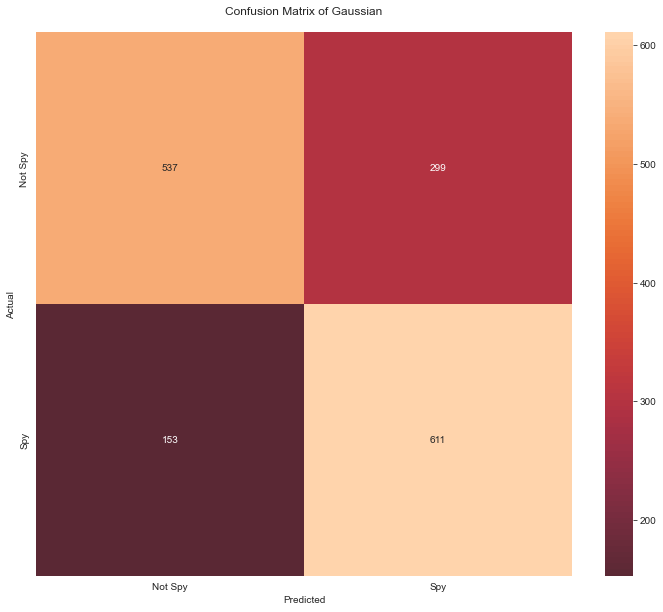

In [88]:
cm_gnb = confusion_matrix(y_val, y_pred_gnb)

plt.figure(figsize=(12,10))

hm_gnb = sns.heatmap(cm_gnb, center=True, annot=True, fmt='.0f')
hm_gnb.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Gaussian\n'
)
hm_gnb.set_xticklabels(['Not Spy', 'Spy'])
hm_gnb.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [89]:
print(f'Gaussian Classification Report\n\n{classification_report(y_val, y_pred_gnb)}')

Gaussian Classification Report

              precision    recall  f1-score   support

           0       0.78      0.64      0.70       836
           1       0.67      0.80      0.73       764

    accuracy                           0.72      1600
   macro avg       0.72      0.72      0.72      1600
weighted avg       0.73      0.72      0.72      1600



###### KNN

In [90]:
modelKNN = KNeighborsClassifier()

In [91]:
modelKNN.fit(X_train, y_train)

KNeighborsClassifier()

In [92]:
# Score for train data
modelKNN.score(X_train, y_train)

0.80328125

In [93]:
# Score for validation data
modelKNN.score(X_val, y_val)

0.725

In [94]:
y_pred_knn = modelKNN.predict(X_val)

acc_train_knn = accuracy_score(y_train, modelKNN.predict(X_train))
acc_knn = accuracy_score(y_val, y_pred_knn)
prec_knn = precision_score(y_val, y_pred_knn)
rec_knn = recall_score(y_val, y_pred_knn)
f1_train_knn = f1_score(y_train, modelKNN.predict(X_train))
f1_knn = f1_score(y_val, y_pred_knn)

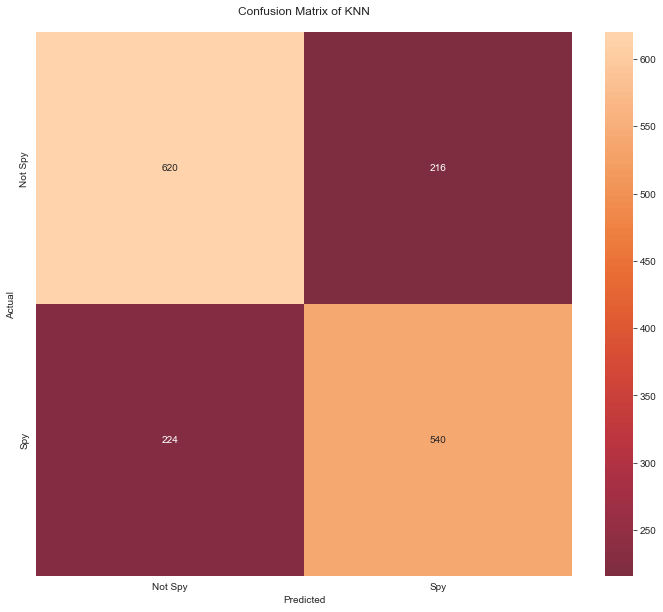

In [95]:
cm_knn = confusion_matrix(y_val, y_pred_knn)

plt.figure(figsize=(12,10))

hm_knn = sns.heatmap(cm_knn, center=True, annot=True, fmt='.0f')
hm_knn.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of KNN\n'
)
hm_knn.set_xticklabels(['Not Spy', 'Spy'])
hm_knn.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [96]:
print(f'KNN Classification Report\n\n{classification_report(y_val, y_pred_knn)}')

KNN Classification Report

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       836
           1       0.71      0.71      0.71       764

    accuracy                           0.73      1600
   macro avg       0.72      0.72      0.72      1600
weighted avg       0.72      0.72      0.72      1600



###### Grid Search KNN

In [97]:
params = {
    'n_neighbors': list(range(1,11)),
    'weights': ['uniform', 'distance']
}

modelGSKNN = KNeighborsClassifier()
modelGSKNN = GridSearchCV(estimator=modelGSKNN, param_grid=params, cv=5, verbose=2, n_jobs=-1)

In [98]:
modelGSKNN.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [99]:
# Score for train data
modelGSKNN.score(X_train, y_train)

0.78140625

In [100]:
# Score for validation data
modelGSKNN.score(X_val, y_val)

0.72375

In [101]:
modelGSKNN.best_params_

{'n_neighbors': 9, 'weights': 'uniform'}

In [102]:
y_pred_gsknn = modelGSKNN.predict(X_val)

acc_train_gsknn = accuracy_score(y_train, modelGSKNN.predict(X_train))
acc_gsknn = accuracy_score(y_val, y_pred_gsknn)
prec_gsknn = precision_score(y_val, y_pred_gsknn)
rec_gsknn = recall_score(y_val, y_pred_gsknn)
f1_train_gsknn = f1_score(y_train, modelGSKNN.predict(X_train))
f1_gsknn = f1_score(y_val, y_pred_gsknn)

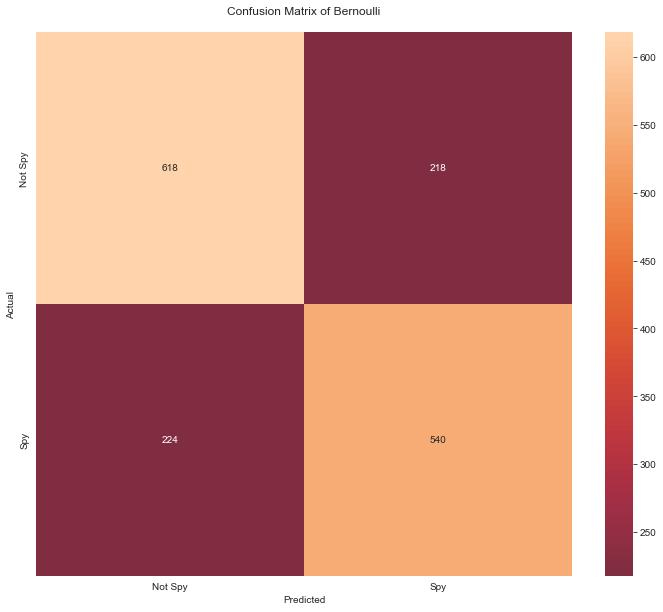

In [103]:
cm_gsknn = confusion_matrix(y_val, y_pred_gsknn)

plt.figure(figsize=(12,10))

hm_gsknn = sns.heatmap(cm_gsknn, center=True, annot=True, fmt='.0f')
hm_gsknn.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Bernoulli\n'
)
hm_gsknn.set_xticklabels(['Not Spy', 'Spy'])
hm_gsknn.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [104]:
print(f'Grid Search KNN Classification Report\n\n{classification_report(y_val, y_pred_gsknn)}')

Grid Search KNN Classification Report

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       836
           1       0.71      0.71      0.71       764

    accuracy                           0.72      1600
   macro avg       0.72      0.72      0.72      1600
weighted avg       0.72      0.72      0.72      1600



###### Bernoulli Naive Bayes

In [105]:
modelBernoulli = BernoulliNB()

In [106]:
modelBernoulli.fit(X_train, y_train)

BernoulliNB()

In [107]:
# Score for train data
modelBernoulli.score(X_train, y_train)

0.7334375

In [108]:
# Score for validation data
modelBernoulli.score(X_val, y_val)

0.72875

In [109]:
y_pred_bnb = modelBernoulli.predict(X_val)

acc_train_bnb = accuracy_score(y_train, modelBernoulli.predict(X_train))
acc_bnb = accuracy_score(y_val, y_pred_bnb)
prec_bnb = precision_score(y_val, y_pred_bnb)
rec_bnb = recall_score(y_val, y_pred_bnb)
f1_train_bnb = f1_score(y_train, modelBernoulli.predict(X_train))
f1_bnb = f1_score(y_val, y_pred_bnb)

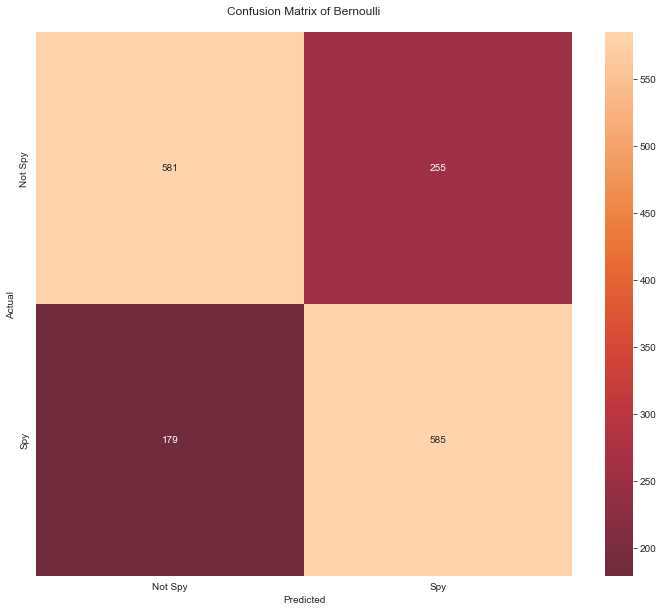

In [110]:
cm_bnb = confusion_matrix(y_val, y_pred_bnb)

plt.figure(figsize=(12,10))

hm_bnb = sns.heatmap(cm_bnb, center=True, annot=True, fmt='.0f')
hm_bnb.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Bernoulli\n'
)
hm_bnb.set_xticklabels(['Not Spy', 'Spy'])
hm_bnb.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [111]:
print(f'Bernoulli Classification Report\n\n{classification_report(y_val, y_pred_bnb)}')

Bernoulli Classification Report

              precision    recall  f1-score   support

           0       0.76      0.69      0.73       836
           1       0.70      0.77      0.73       764

    accuracy                           0.73      1600
   macro avg       0.73      0.73      0.73      1600
weighted avg       0.73      0.73      0.73      1600



###### Decision Tree

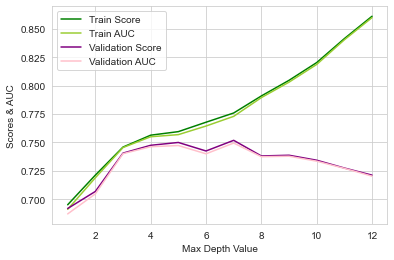

In [112]:
scores_train = []
scores_val = []
auc_train = []
auc_val = []

max_depths = range(1,13)

for depth in max_depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    
    scores_train.append(decision_tree.score(X_train, y_train))
    scores_val.append(decision_tree.score(X_val, y_val))
    
    decision_tree_train_pred = decision_tree.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, decision_tree_train_pred) 
    roc_auc = auc(false_positive_rate, true_positive_rate)
    auc_train.append(roc_auc)
    
    decision_tree_val_pred = decision_tree.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, decision_tree_val_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    auc_val.append(roc_auc)
    
plt.plot(max_depths, scores_train, label="Train Score", color='green')
plt.plot(max_depths, auc_train, label='Train AUC', color='yellowgreen')
plt.plot(max_depths, scores_val, label="Validation Score", color='purple')
plt.plot(max_depths, auc_val, label='Validation AUC', color='pink')

plt.xlabel("Max Depth Value")
plt.ylabel('Scores & AUC')
plt.legend()

plt.show()

In [113]:
modelDT = DecisionTreeClassifier(max_depth=6)

In [114]:
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [115]:
# Score for train data
modelDT.score(X_train, y_train)

0.7678125

In [116]:
# Score for validation data
modelDT.score(X_val, y_val)

0.740625

In [117]:
modelDT_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [118]:
modelDT_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [119]:
# Score for train data
modelDT_entropy.score(X_train, y_train)

0.7671875

In [120]:
# Score for validation data
modelDT_entropy.score(X_val, y_val)

0.743125

<font color='#235731'><b>NOTE:</b> Since the Decision Tree Classifier using 'entropy' as the function to measure the quality of a split provided better results on the test data without performing significatly worse in training comparatively to the one using 'gini', it will be the model chose</font>

In [121]:
y_pred_dt = modelDT_entropy.predict(X_val)

acc_train_dt = accuracy_score(y_train, modelDT_entropy.predict(X_train))
acc_dt = accuracy_score(y_val, y_pred_dt)
prec_dt = precision_score(y_val, y_pred_dt)
rec_dt = recall_score(y_val, y_pred_dt)
f1_train_dt = f1_score(y_train, modelDT_entropy.predict(X_train))
f1_dt = f1_score(y_val, y_pred_dt)

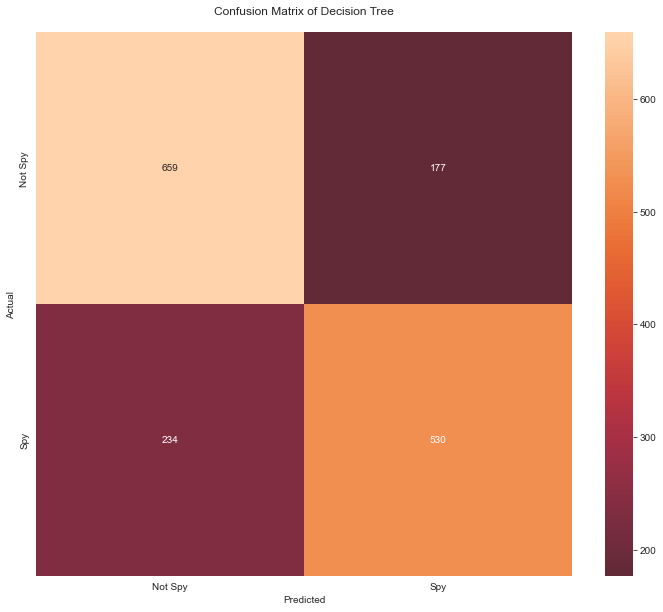

In [122]:
cm_dt = confusion_matrix(y_val, y_pred_dt)

plt.figure(figsize=(12,10))

hm_dt = sns.heatmap(cm_dt, center=True, annot=True, fmt='.0f')
hm_dt.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Decision Tree\n'
)
hm_dt.set_xticklabels(['Not Spy', 'Spy'])
hm_dt.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [123]:
print(f'Decision Tree Classification Report\n\n{classification_report(y_val, y_pred_dt)}')

Decision Tree Classification Report

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       836
           1       0.75      0.69      0.72       764

    accuracy                           0.74      1600
   macro avg       0.74      0.74      0.74      1600
weighted avg       0.74      0.74      0.74      1600



###### Grid Search Decision Tree

In [124]:
params = {
    'max_depth': [3, 4, 5, 6, 7],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [1, 2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
}

modelGSDT = DecisionTreeClassifier()
modelGSDT = GridSearchCV(estimator=modelGSDT, param_grid=params, cv=5, verbose=2, n_jobs=-1)

In [125]:
modelGSDT.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [1, 2, 3, 5]},
             verbose=2)

In [126]:
# Score for train data
modelGSDT.score(X_train, y_train)

0.75640625

In [127]:
# Score for validation data
modelGSDT.score(X_val, y_val)

0.7475

In [128]:
modelGSDT.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

<font color='#235731'><b>NOTE:</b> Like in the Decision Tree model, the Bagging Classifier using Decision Tree with the 'entropy' as criteria performed better than the one using 'gini' as the function to define the quality of the split</font>

In [129]:
y_pred_gsdt = modelGSDT.predict(X_val)

acc_train_gsdt = accuracy_score(y_train, modelGSDT.predict(X_train))
acc_gsdt = accuracy_score(y_val, y_pred_gsdt)
prec_gsdt = precision_score(y_val, y_pred_gsdt)
rec_gsdt = recall_score(y_val, y_pred_gsdt)
f1_train_gsdt = f1_score(y_train, modelGSDT.predict(X_train))
f1_gsdt = f1_score(y_val, y_pred_gsdt)

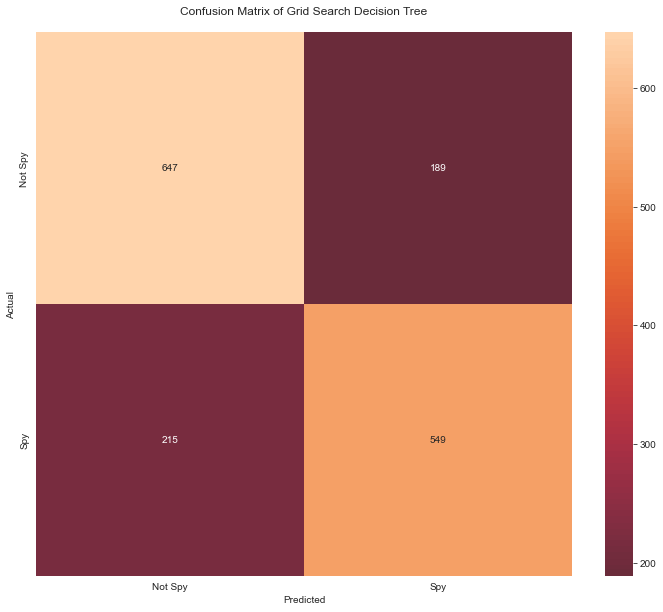

In [130]:
cm_gsdt = confusion_matrix(y_val, y_pred_gsdt)

plt.figure(figsize=(12,10))

hm_gsdt = sns.heatmap(cm_gsdt, center=True, annot=True, fmt='.0f')
hm_gsdt.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Grid Search Decision Tree\n'
)
hm_gsdt.set_xticklabels(['Not Spy', 'Spy'])
hm_gsdt.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [131]:
print(f'Grid Search Decision Tree Classification Report\n\n{classification_report(y_val, y_pred_gsdt)}')

Grid Search Decision Tree Classification Report

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       836
           1       0.74      0.72      0.73       764

    accuracy                           0.75      1600
   macro avg       0.75      0.75      0.75      1600
weighted avg       0.75      0.75      0.75      1600



###### Bagging Decision Tree

In [132]:
modelBDT = BaggingClassifier(base_estimator=modelDT)

In [133]:
modelBDT.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6))

In [134]:
# Score for train data
modelBDT.score(X_train, y_train)

0.771875

In [135]:
# Score for validation data
modelBDT.score(X_val, y_val)

0.74875

In [136]:
modelBDT_entropy = BaggingClassifier(base_estimator=modelDT_entropy)

In [137]:
modelBDT_entropy.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=6))

In [138]:
# Score for train data
modelBDT_entropy.score(X_train, y_train)

0.77421875

In [139]:
# Score for validation data
modelBDT_entropy.score(X_val, y_val)

0.756875

In [140]:
y_pred_bdt = modelBDT_entropy.predict(X_val)

acc_train_bdt = accuracy_score(y_train, modelBDT_entropy.predict(X_train))
acc_bdt = accuracy_score(y_val, y_pred_bdt)
prec_bdt = precision_score(y_val, y_pred_bdt)
rec_bdt = recall_score(y_val, y_pred_bdt)
f1_train_bdt = f1_score(y_train, modelBDT_entropy.predict(X_train))
f1_bdt = f1_score(y_val, y_pred_bdt)

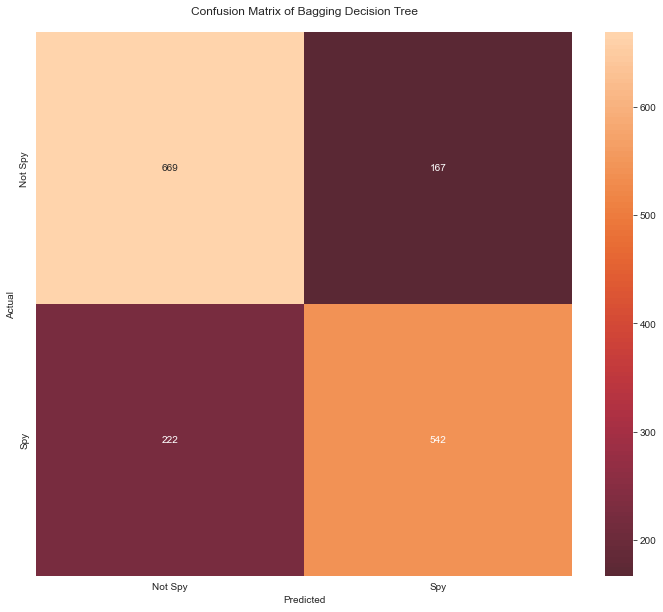

In [141]:
cm_bdt = confusion_matrix(y_val, y_pred_bdt)

plt.figure(figsize=(12,10))

hm_bdt = sns.heatmap(cm_bdt, center=True, annot=True, fmt='.0f')
hm_bdt.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Bagging Decision Tree\n'
)
hm_bdt.set_xticklabels(['Not Spy', 'Spy'])
hm_bdt.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [142]:
print(f'Bagging Decision Tree Classification Report\n\n{classification_report(y_val, y_pred_bdt)}')

Bagging Decision Tree Classification Report

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       836
           1       0.76      0.71      0.74       764

    accuracy                           0.76      1600
   macro avg       0.76      0.75      0.76      1600
weighted avg       0.76      0.76      0.76      1600



###### Random Forest

In [143]:
modelRF = RandomForestClassifier()

In [144]:
modelRF.fit(X_train, y_train)

RandomForestClassifier()

In [145]:
# Score for train data
modelRF.score(X_train, y_train)

0.97453125

In [146]:
# Score for validation data
modelRF.score(X_val, y_val)

0.718125

In [147]:
y_pred_rf = modelRF.predict(X_val)

acc_train_rf = accuracy_score(y_train, modelRF.predict(X_train))
acc_rf = accuracy_score(y_val, y_pred_rf)
prec_rf = precision_score(y_val, y_pred_rf)
rec_rf = recall_score(y_val, y_pred_rf)
f1_train_rf = f1_score(y_train, modelRF.predict(X_train))
f1_rf = f1_score(y_val, y_pred_rf)

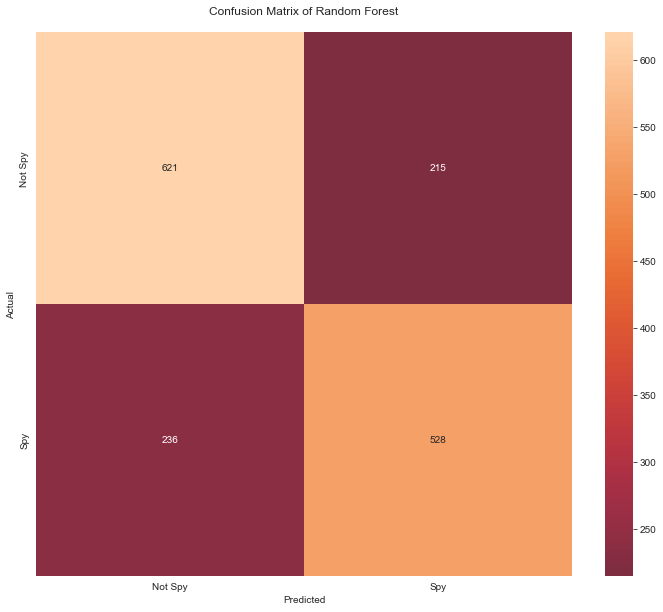

In [148]:
cm_rf = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(12,10))

hm_rf = sns.heatmap(cm_rf, center=True, annot=True, fmt='.0f')
hm_rf.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Random Forest\n'
)
hm_rf.set_xticklabels(['Not Spy', 'Spy'])
hm_rf.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [149]:
print(f'Random Forest Classification Report\n\n{classification_report(y_val, y_pred_rf)}')

Random Forest Classification Report

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       836
           1       0.71      0.69      0.70       764

    accuracy                           0.72      1600
   macro avg       0.72      0.72      0.72      1600
weighted avg       0.72      0.72      0.72      1600



###### Grid Search Random Forest

In [150]:
#params = {
#    'bootstrap': [True],
#    'max_depth': list(range(2,11)),
#    'min_samples_split': [2, 4, 6],
#    'min_samples_leaf': [1, 3, 5],
#    'n_estimators': [100, 200, 300]
#}
#
#modelGSRF = RandomForestClassifier()
#modelGSRF = GridSearchCV(estimator=modelGSRF, param_grid=params, cv=5, verbose=2, n_jobs=-1)

In [151]:
#modelGSRF.fit(X_train, y_train)

In [152]:
# Score for train data
#modelGSRF.score(X_train, y_train)

<font color='#235731'><b>NOTE:</b> Training Score: 0.795625</font>

In [153]:
#Score for validation data
#modelGSRF.score(X_val, y_val)

<font color='#235731'><b>NOTE:</b> Validation Score: 0.7625</font>

In [154]:
#modelGSRF.best_params_

<font color='#235731'><b>NOTE:</b> After running Grid Search with the estimator as RandomForestClassifier the best params are:</font><br>
 - <font color='#235731'>'bootstrap': True,</font>
 - <font color='#235731'>'max_depth': 10,</font>
 - <font color='#235731'>'min_samples_leaf': 3</font>
 - <font color='#235731'>'min_samples_split': 4</font>
 - <font color='#235731'>'n_estimators': 100</font>

In [155]:
# Best params without overfitting
modelGSRF = RandomForestClassifier(
    bootstrap=True,
    max_depth=9,
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=300,
)

In [156]:
modelGSRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=300)

In [157]:
# Score for train data
modelGSRF.score(X_train, y_train)

0.79265625

In [158]:
# Score for validation data
modelGSRF.score(X_val, y_val)

0.76

In [159]:
y_pred_gsrf = modelGSRF.predict(X_val)

acc_train_gsrf = accuracy_score(y_train, modelGSRF.predict(X_train))
acc_gsrf = accuracy_score(y_val, y_pred_gsrf)
prec_gsrf = precision_score(y_val, y_pred_gsrf)
rec_gsrf = recall_score(y_val, y_pred_gsrf)
f1_train_gsrf = f1_score(y_train, modelGSRF.predict(X_train))
f1_gsrf = f1_score(y_val, y_pred_gsrf)

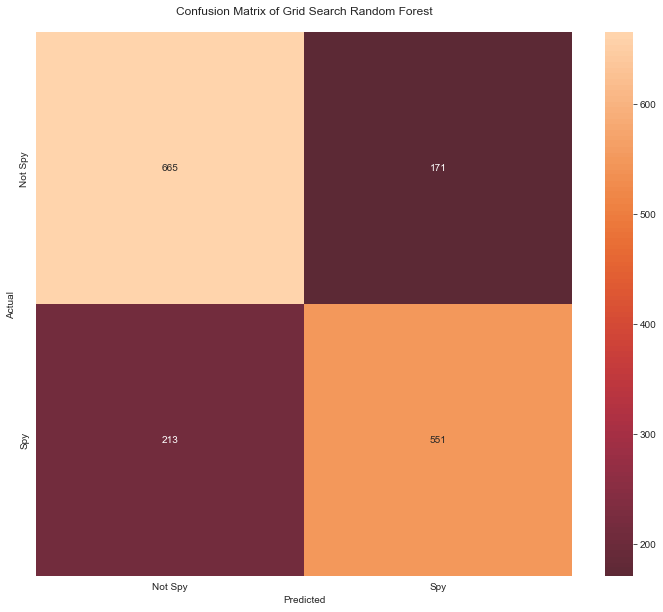

In [160]:
cm_gsrf = confusion_matrix(y_val, y_pred_gsrf)

plt.figure(figsize=(12,10))

hm_gsrf = sns.heatmap(cm_gsrf, center=True, annot=True, fmt='.0f')
hm_gsrf.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Grid Search Random Forest\n'
)
hm_gsrf.set_xticklabels(['Not Spy', 'Spy'])
hm_gsrf.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [161]:
print(f'Grid Search Random Forest Classification Report\n\n{classification_report(y_val, y_pred_gsrf)}')

Grid Search Random Forest Classification Report

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       836
           1       0.76      0.72      0.74       764

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.76      1600
weighted avg       0.76      0.76      0.76      1600



###### AdaBoost

In [162]:
modelAB = AdaBoostClassifier()

In [163]:
modelAB.fit(X_train, y_train)

AdaBoostClassifier()

In [164]:
# Score for train data
modelAB.score(X_train, y_train)

0.74984375

In [165]:
# Score for validation data
modelAB.score(X_val, y_val)

0.741875

In [166]:
y_pred_ab = modelAB.predict(X_val)

acc_train_ab = accuracy_score(y_train, modelAB.predict(X_train))
acc_ab = accuracy_score(y_val, y_pred_ab)
prec_ab = precision_score(y_val, y_pred_ab)
rec_ab = recall_score(y_val, y_pred_ab)
f1_train_ab = f1_score(y_train, modelAB.predict(X_train))
f1_ab = f1_score(y_val, y_pred_ab)

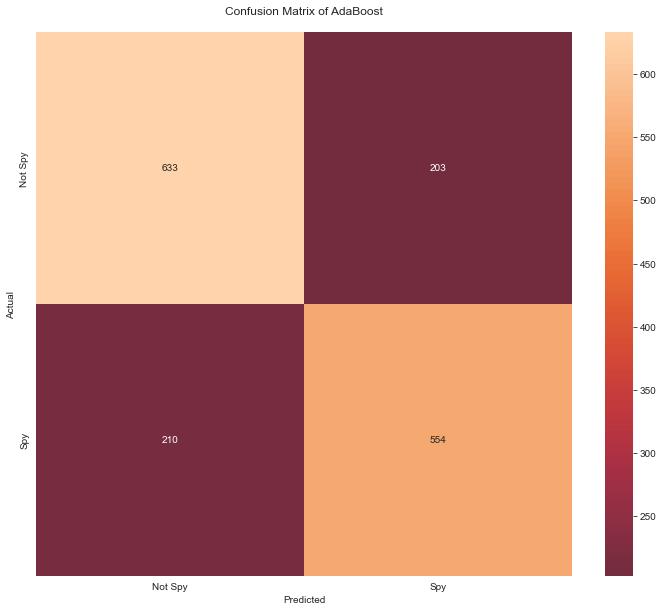

In [167]:
cm_ab = confusion_matrix(y_val, y_pred_ab)

plt.figure(figsize=(12,10))

hm_ab = sns.heatmap(cm_ab, center=True, annot=True, fmt='.0f')
hm_ab.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of AdaBoost\n'
)
hm_ab.set_xticklabels(['Not Spy', 'Spy'])
hm_ab.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [168]:
print(f'AdaBoost Classification Report\n\n{classification_report(y_val, y_pred_ab)}')

AdaBoost Classification Report

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       836
           1       0.73      0.73      0.73       764

    accuracy                           0.74      1600
   macro avg       0.74      0.74      0.74      1600
weighted avg       0.74      0.74      0.74      1600



###### Grid Search AdaBoost

In [169]:
params = {
    'learning_rate': [0.02, 0.05, 0.07, 0.1],
    'n_estimators': [100, 200, 300]
}

modelGSAB = AdaBoostClassifier()
modelGSAB = GridSearchCV(estimator=modelGSAB, param_grid=params, cv=5, verbose=2, n_jobs=-1)

In [170]:
modelGSAB.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05, 0.07, 0.1],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [171]:
# Score for train data
modelGSAB.score(X_train, y_train)

0.75265625

<font color='#235731'><b>NOTE:</b> Training Score: 0.75015625</font>

In [172]:
# Score for validation data
modelGSAB.score(X_val, y_val)

0.74875

<font color='#235731'><b>NOTE:</b> Validation Score: 0.751875</font>

In [173]:
modelGSAB.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [174]:
y_pred_gsab = modelGSAB.predict(X_val)

acc_train_gsab = accuracy_score(y_train, modelGSAB.predict(X_train))
acc_gsab = accuracy_score(y_val, y_pred_gsab)
prec_gsab = precision_score(y_val, y_pred_gsab)
rec_gsab = recall_score(y_val, y_pred_gsab)
f1_train_gsab = f1_score(y_train, modelGSAB.predict(X_train))
f1_gsab = f1_score(y_val, y_pred_gsab)

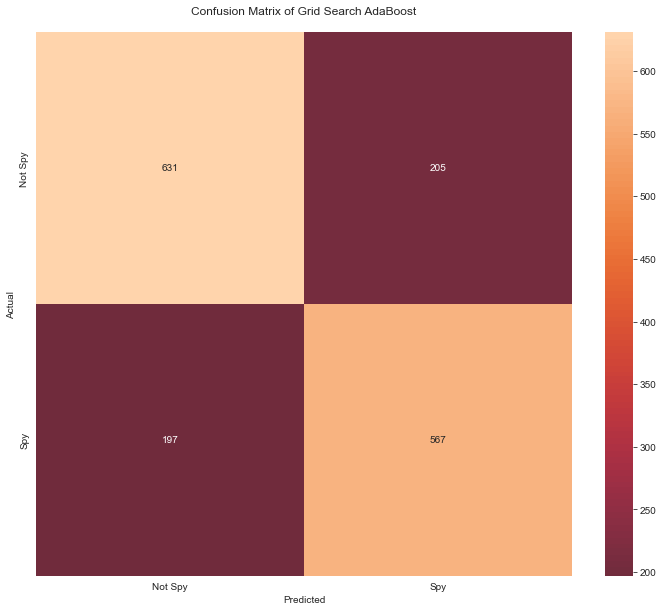

In [175]:
cm_gsab = confusion_matrix(y_val, y_pred_gsab)

plt.figure(figsize=(12,10))

hm_gsab = sns.heatmap(cm_gsab, center=True, annot=True, fmt='.0f')
hm_gsab.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Grid Search AdaBoost\n'
)
hm_gsab.set_xticklabels(['Not Spy', 'Spy'])
hm_gsab.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [176]:
print(f'Grid Search AdaBoost Classification Report\n\n{classification_report(y_val, y_pred_gsab)}')

Grid Search AdaBoost Classification Report

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       836
           1       0.73      0.74      0.74       764

    accuracy                           0.75      1600
   macro avg       0.75      0.75      0.75      1600
weighted avg       0.75      0.75      0.75      1600



###### SVC

In [177]:
modelSVC = SVC(kernel='linear', C=1, gamma=1)

In [178]:
modelSVC.fit(X_train, y_train)

SVC(C=1, gamma=1, kernel='linear')

In [179]:
# Score for train data
modelSVC.score(X_train, y_train)

0.72859375

In [180]:
# Score for validation data
modelSVC.score(X_val, y_val)

0.723125

In [181]:
y_pred_svc = modelSVC.predict(X_val)

acc_train_svc = accuracy_score(y_train, modelSVC.predict(X_train))
acc_svc = accuracy_score(y_val, y_pred_svc)
prec_svc = precision_score(y_val, y_pred_svc)
rec_svc = recall_score(y_val, y_pred_svc)
f1_train_svc = f1_score(y_train, modelSVC.predict(X_train))
f1_svc = f1_score(y_val, y_pred_svc)

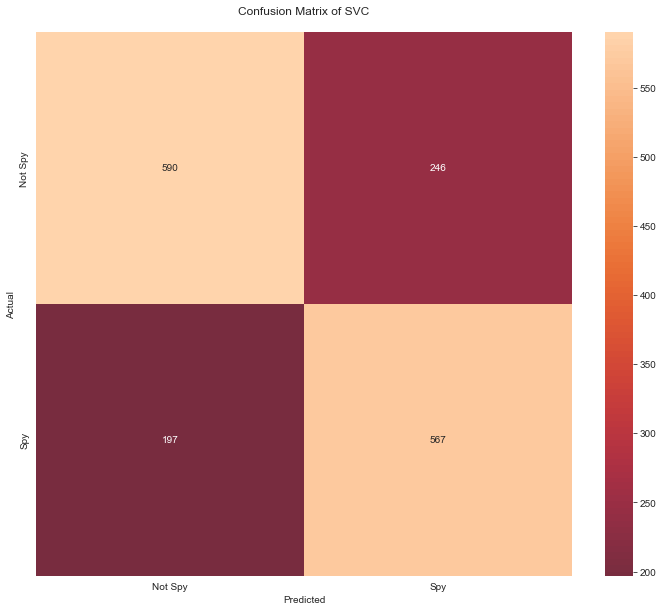

In [182]:
cm_svc = confusion_matrix(y_val, y_pred_svc)

plt.figure(figsize=(12,10))

hm_svc = sns.heatmap(cm_svc, center=True, annot=True, fmt='.0f')
hm_svc.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of SVC\n'
)
hm_svc.set_xticklabels(['Not Spy', 'Spy'])
hm_svc.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [183]:
print(f'SVC Classification Report\n\n{classification_report(y_val, y_pred_svc)}')

SVC Classification Report

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       836
           1       0.70      0.74      0.72       764

    accuracy                           0.72      1600
   macro avg       0.72      0.72      0.72      1600
weighted avg       0.72      0.72      0.72      1600



###### Gradient Boosting

In [184]:
learning_rates = [0.07, 0.09, 0.1, 0.11, 0.13]

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate)
    gb.fit(X_train, y_train)
    print(f'Learning Rate: {learning_rate}')
    print('Accuracy score (Training): {0:.3f}'.format(gb.score(X_train, y_train)))
    print('Accuracy score (Validation): {0:.3f}'.format(gb.score(X_val, y_val)))
    print('---//---')

Learning Rate: 0.07
Accuracy score (Training): 0.770
Accuracy score (Validation): 0.754
---//---
Learning Rate: 0.09
Accuracy score (Training): 0.773
Accuracy score (Validation): 0.759
---//---
Learning Rate: 0.1
Accuracy score (Training): 0.775
Accuracy score (Validation): 0.760
---//---
Learning Rate: 0.11
Accuracy score (Training): 0.776
Accuracy score (Validation): 0.762
---//---
Learning Rate: 0.13
Accuracy score (Training): 0.778
Accuracy score (Validation): 0.759
---//---


In [185]:
modelGB = GradientBoostingClassifier(learning_rate=0.09)

In [186]:
modelGB.fit(X_train ,y_train)

GradientBoostingClassifier(learning_rate=0.09)

In [187]:
# Score for train data
modelGB.score(X_train, y_train)

0.77328125

In [188]:
# Score for validation data
modelGB.score(X_val, y_val)

0.75875

In [189]:
y_pred_gb = modelGB.predict(X_val)

acc_train_gb = accuracy_score(y_train, modelGB.predict(X_train))
acc_gb = accuracy_score(y_val, y_pred_gb)
prec_gb = precision_score(y_val, y_pred_gb)
rec_gb = recall_score(y_val, y_pred_gb)
f1_train_gb = f1_score(y_train, modelGB.predict(X_train))
f1_gb = f1_score(y_val, y_pred_gb)

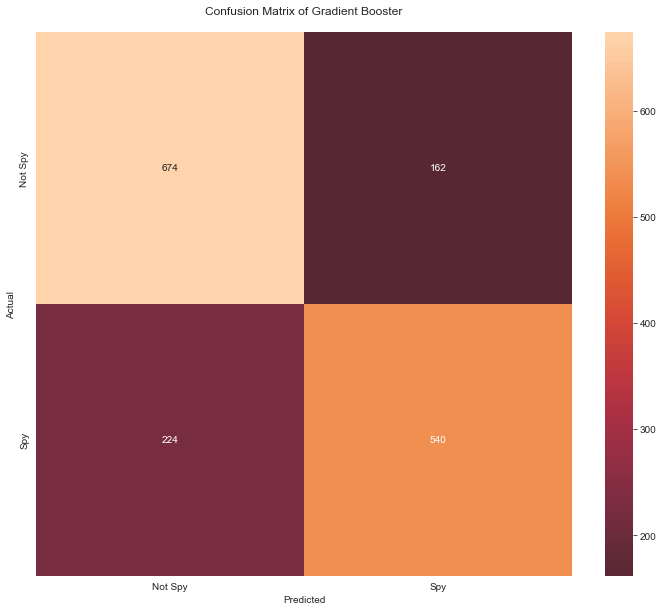

In [190]:
cm_gb = confusion_matrix(y_val, y_pred_gb)

plt.figure(figsize=(12,10))

hm_gb = sns.heatmap(cm_gb, center=True, annot=True, fmt='.0f')
hm_gb.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Gradient Booster\n'
)
hm_gb.set_xticklabels(['Not Spy', 'Spy'])
hm_gb.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [191]:
print(f'Gradient Booster Classification Report\n\n{classification_report(y_val, y_pred_gb)}')

Gradient Booster Classification Report

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       836
           1       0.77      0.71      0.74       764

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.76      1600
weighted avg       0.76      0.76      0.76      1600



###### Grid Search Gradient Boosting

In [192]:
#params = {
#    'learning_rate': [0.02, 0.05, 0.09, 0.11],
#    'max_depth': list(range(2,11)),
#    'min_samples_split': [2, 4, 6, 8],
#    'min_samples_leaf': [1, 3, 5],
#    'n_estimators': [50, 100, 200, 300, 500]
#}
#
#modelGSGB = GradientBoostingClassifier()
#modelGSGB = GridSearchCV(
#    estimator=modelGSGB,
#    param_grid=params,
#    cv=5,
#    verbose=2,
#    n_jobs=-1)

In [193]:
#modelGSGB.fit(X_train ,y_train)

In [194]:
# Score for train data
#modelGSGB.score(X_train, y_train)

<font color='#235731'><b>NOTE:</b> Training Score: 0.78078125</font>

In [195]:
# Score for validation data
#modelGSGB.score(X_val, y_val)

<font color='#235731'><b>NOTE:</b> Validation Score: 0.761875</font>

In [196]:
#modelGSGB.best_params_

<font color='#235731'><b>NOTE:</b> After running Grid Search with the estimator as GradientBoostingClassifier the best params are:</font><br>
 - <font color='#235731'>'learning_rate': 0.09</font>
 - <font color='#235731'>'min_samples_leaf': 3</font>
 - <font color='#235731'>'min_samples_split': 2</font>
 - <font color='#235731'>'n_estimators': 200</font>


 - <font color='#235731'>'learning_rate': 0.12</font>
 - <font color='#235731'>'min_samples_leaf': 5</font>
 - <font color='#235731'>'max_depth': 3</font>
 - <font color='#235731'>'min_samples_split': 2</font>
 - <font color='#235731'>'n_estimators': 100</font>

In [197]:
modelGSGB = GradientBoostingClassifier(
    learning_rate=0.09,
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=200,
)

In [198]:
modelGSGB.fit(X_train ,y_train)

GradientBoostingClassifier(learning_rate=0.09, min_samples_leaf=3,
                           n_estimators=200)

In [199]:
# Score for train data
modelGSGB.score(X_train, y_train)

0.7815625

In [200]:
# Score for validation data
modelGSGB.score(X_val, y_val)

0.764375

In [201]:
y_pred_gsgb = modelGSGB.predict(X_val)

acc_train_gsgb = accuracy_score(y_train, modelGSGB.predict(X_train))
acc_gsgb = accuracy_score(y_val, y_pred_gsgb)
prec_gsgb = precision_score(y_val, y_pred_gsgb)
rec_gsgb = recall_score(y_val, y_pred_gsgb)
f1_train_gsgb = f1_score(y_train, modelGSGB.predict(X_train))
f1_gsgb = f1_score(y_val, y_pred_gsgb)

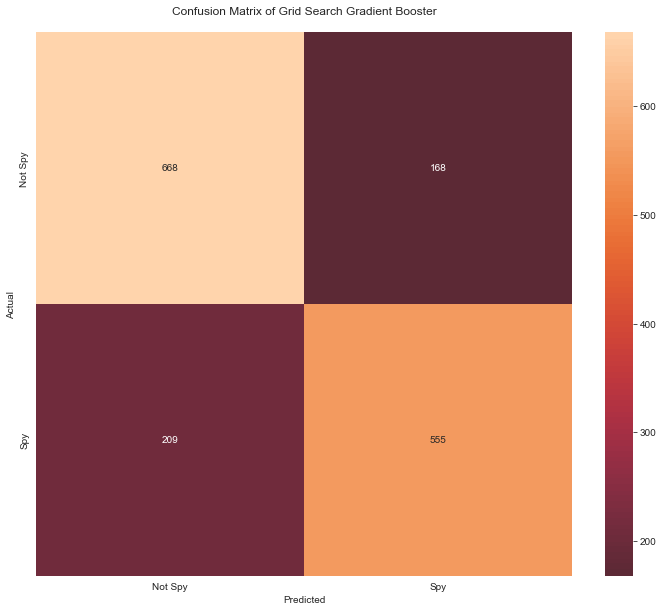

In [202]:
cm_gsgb = confusion_matrix(y_val, y_pred_gsgb)

plt.figure(figsize=(12,10))

hm_gsgb = sns.heatmap(cm_gsgb, center=True, annot=True, fmt='.0f')
hm_gsgb.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Grid Search Gradient Booster\n'
)
hm_gsgb.set_xticklabels(['Not Spy', 'Spy'])
hm_gsgb.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [203]:
print(f'Grid Search Gradient Booster Classification Report\n\n{classification_report(y_val, y_pred_gsgb)}')

Grid Search Gradient Booster Classification Report

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       836
           1       0.77      0.73      0.75       764

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.76      1600
weighted avg       0.76      0.76      0.76      1600



**MLP Classifier**

In [204]:
modelMLP = MLPClassifier(max_iter=500 , activation='tanh', learning_rate_init=0.08,
                         solver='sgd', learning_rate = 'adaptive', momentum=0.9, 
                         hidden_layer_sizes=(8,6,2), batch_size=5)

In [205]:
modelMLP.fit(X_train, y_train)

MLPClassifier(activation='tanh', batch_size=5, hidden_layer_sizes=(8, 6, 2),
              learning_rate='adaptive', learning_rate_init=0.08, max_iter=500,
              solver='sgd')

In [206]:
# Score for train data
modelMLP.score(X_train, y_train)

0.77609375

In [207]:
# Score for validation data
modelMLP.score(X_val, y_val)

0.739375

In [208]:
y_pred_mlp = modelMLP.predict(X_val)

acc_train_mlp = accuracy_score(y_train, modelMLP.predict(X_train))
acc_mlp = accuracy_score(y_val, y_pred_mlp)
prec_mlp = precision_score(y_val, y_pred_mlp)
rec_mlp = recall_score(y_val, y_pred_mlp)
f1_train_mlp = f1_score(y_train, modelMLP.predict(X_train))
f1_mlp = f1_score(y_val, y_pred_mlp)

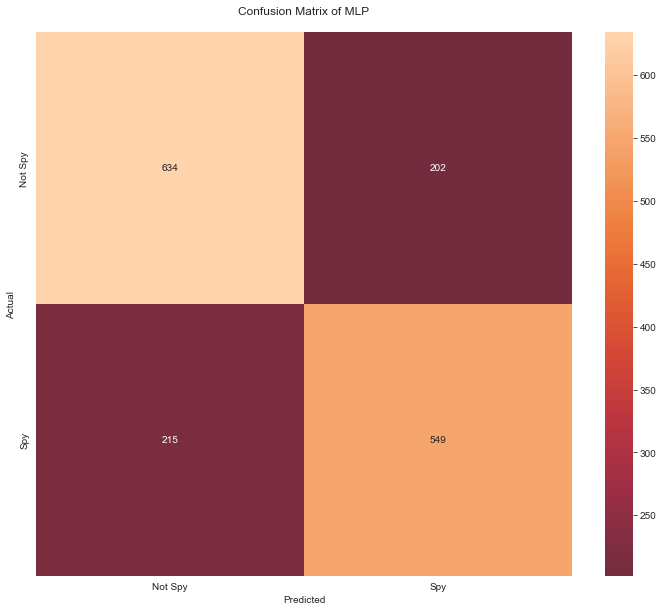

In [209]:
cm_mlp = confusion_matrix(y_val, y_pred_mlp)

plt.figure(figsize=(12,10))

hm_mlp = sns.heatmap(cm_mlp, center=True, annot=True, fmt='.0f')
hm_mlp.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of MLP\n'
)
hm_mlp.set_xticklabels(['Not Spy', 'Spy'])
hm_mlp.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [210]:
print(f'MLP Classification Report\n\n{classification_report(y_val, y_pred_mlp)}')

MLP Classification Report

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       836
           1       0.73      0.72      0.72       764

    accuracy                           0.74      1600
   macro avg       0.74      0.74      0.74      1600
weighted avg       0.74      0.74      0.74      1600



###### Passive Agressive Classifier

In [211]:
modelPA = PassiveAggressiveClassifier(C=0.05)

In [212]:
modelPA.fit(X_train, y_train)

PassiveAggressiveClassifier(C=0.05)

In [213]:
# Score for train data
modelPA.score(X_train, y_train)

0.72671875

In [214]:
# Score for validation data
modelPA.score(X_val, y_val)

0.72

In [215]:
y_pred_pa = modelPA.predict(X_val)

acc_train_pa = accuracy_score(y_train, modelPA.predict(X_train))
acc_pa = accuracy_score(y_val, y_pred_pa)
prec_pa = precision_score(y_val, y_pred_pa)
rec_pa = recall_score(y_val, y_pred_pa)
f1_train_pa = f1_score(y_train, modelPA.predict(X_train))
f1_pa = f1_score(y_val, y_pred_pa)

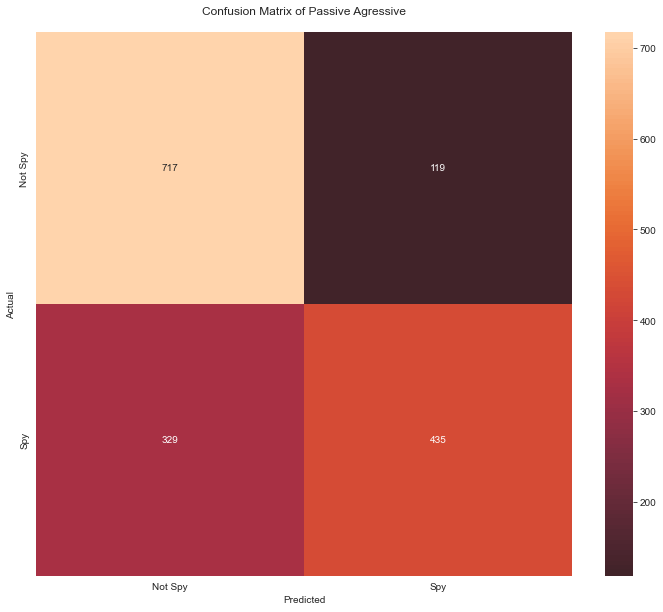

In [216]:
cm_pa = confusion_matrix(y_val, y_pred_pa)

plt.figure(figsize=(12,10))

hm_pa = sns.heatmap(cm_pa, center=True, annot=True, fmt='.0f')
hm_pa.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Passive Agressive\n'
)
hm_pa.set_xticklabels(['Not Spy', 'Spy'])
hm_pa.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [217]:
print(f'Passive Agressive Classification Report\n\n{classification_report(y_val, y_pred_pa)}')

Passive Agressive Classification Report

              precision    recall  f1-score   support

           0       0.69      0.86      0.76       836
           1       0.79      0.57      0.66       764

    accuracy                           0.72      1600
   macro avg       0.74      0.71      0.71      1600
weighted avg       0.73      0.72      0.71      1600



###### Stacking Classifier

In [218]:
modelStack = StackingClassifier(
    estimators=[
        ('gsrf', modelGSRF),
        ('gsgb', modelGSGB),
        ('gb', modelGB),
    ],
    final_estimator=LogisticRegressionCV(cv=5),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

In [219]:
modelStack.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('gsrf',
                                RandomForestClassifier(max_depth=9,
                                                       min_samples_leaf=3,
                                                       n_estimators=300)),
                               ('gsgb',
                                GradientBoostingClassifier(learning_rate=0.09,
                                                           min_samples_leaf=3,
                                                           n_estimators=200)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.09))],
                   final_estimator=LogisticRegressionCV(cv=5), n_jobs=-1,
                   stack_method='predict_proba')

In [220]:
# Score for train data
modelStack.score(X_train, y_train)

0.78890625

<font color='#235731'><b>NOTE:</b> Training Score: 0.78875</font>

In [221]:
# Score for validation data
modelStack.score(X_val, y_val)

0.7625

<font color='#235731'><b>NOTE:</b> Validation Score: 0.768125</font>

In [222]:
y_pred_stack = modelStack.predict(X_val)

acc_train_stack = accuracy_score(y_train, modelStack.predict(X_train))
acc_stack = accuracy_score(y_val, y_pred_stack)
prec_stack = precision_score(y_val, y_pred_stack)
rec_stack = recall_score(y_val, y_pred_stack)
f1_train_stack = f1_score(y_train, modelStack.predict(X_train))
f1_stack = f1_score(y_val, y_pred_stack)

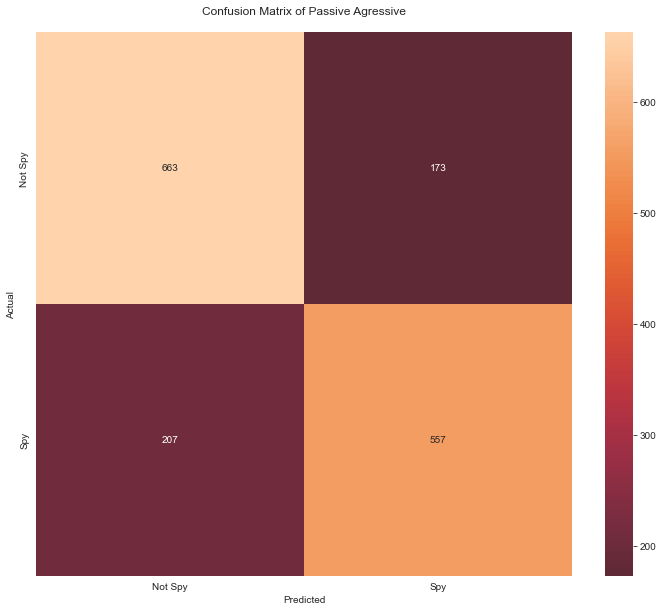

In [223]:
cm_stack = confusion_matrix(y_val, y_pred_stack)

plt.figure(figsize=(12,10))

hm_stack = sns.heatmap(cm_stack, center=True, annot=True, fmt='.0f')
hm_stack.set(
    xlabel = 'Predicted',
    ylabel = 'Actual',
    title = 'Confusion Matrix of Passive Agressive\n'
)
hm_stack.set_xticklabels(['Not Spy', 'Spy'])
hm_stack.set_yticklabels(['Not Spy', 'Spy'])

plt.show()

In [224]:
print(f'Stacking Classifier Classification Report\n\n{classification_report(y_val, y_pred_stack)}')

Stacking Classifier Classification Report

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       836
           1       0.76      0.73      0.75       764

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.76      1600
weighted avg       0.76      0.76      0.76      1600



### <font color='#BFD72F'>6. Analysing Results</font><a class="anchor" id="results"></a>

In [225]:
accuracies = [
    acc_gnb, acc_knn, acc_bnb, acc_dt, acc_bdt,
    acc_rf, acc_gsab, acc_ab, acc_gsdt, acc_gsrf, acc_gsgb,
    acc_svc, acc_gb, acc_mlp, acc_pa, acc_stack
]

models = ['GNB', 'KNN', 'BNB', 'DT', 'B-DT', 'RF', 'GSAB', 'AB', 'GS-DT', 'GS-RF', 'GS-GB', 'SVC', 'GB', 'MLP', 'PA', 'Stack']

In [226]:
data_tuples = list(zip(models, accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)

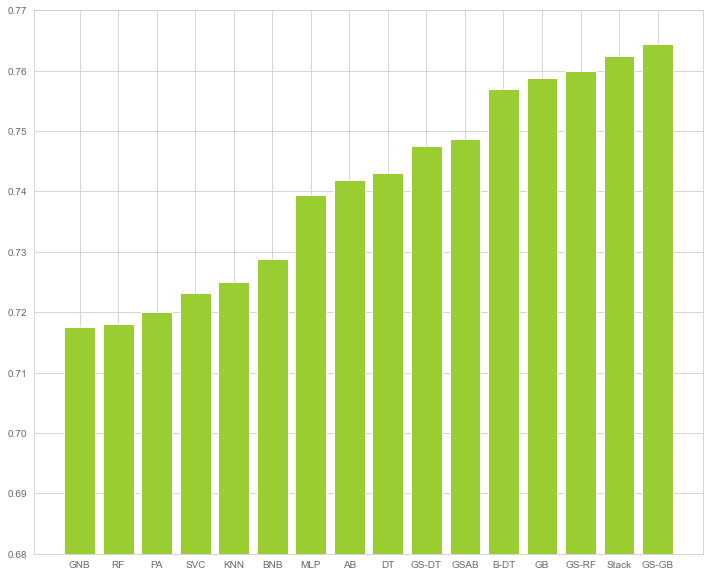

In [227]:
plt.figure(figsize=(12,10))

plt.bar(data[0], data[1], color='yellowgreen')
plt.xticks(color='dimgray')
plt.yticks(color='dimgray')
plt.ylim(0.68,0.77)
plt.show()

In [228]:
results = pd.DataFrame(
    [
        ['Gaussian', acc_train_gnb, acc_gnb, prec_gnb, rec_gnb, f1_train_gnb, f1_gnb],
        ['KNN', acc_train_knn, acc_knn, prec_knn, rec_knn, f1_train_knn, f1_knn],
        ['Bernoulli', acc_train_bnb, acc_bnb, prec_bnb, rec_bnb, f1_train_bnb, f1_bnb],
        ['Decision Tree', acc_train_dt, acc_dt, prec_dt, rec_dt, f1_train_dt, f1_dt],
        ['Bagging Decision Tree', acc_train_bdt, acc_bdt, prec_bdt, rec_bdt, f1_train_bdt, f1_bdt],
        ['Random Forest', acc_train_rf, acc_rf, prec_rf, rec_rf, f1_train_rf, f1_rf],
        ['Grid Search AdaBoost', acc_train_gsab, acc_gsab, prec_gsab, rec_gsab, f1_train_gsab, f1_gsab],
        ['AdaBoost', acc_train_ab, acc_ab, prec_ab, rec_ab, f1_train_ab, f1_ab],
        ['Grid Search Decision Tree', acc_train_gsdt, acc_gsdt, prec_gsdt, rec_gsdt, f1_train_gsdt, f1_gsdt],
        ['Grid Search Random Forest', acc_train_gsrf, acc_gsrf, prec_gsrf, rec_gsrf, f1_train_gsrf, f1_gsrf],
        ['Grid Search Gradient Booster', acc_train_gsgb, acc_gsgb, prec_gsgb, rec_gsgb, f1_train_gsgb, f1_gsgb],
        ['SVC', acc_train_svc, acc_svc, prec_svc, rec_svc, f1_train_svc, f1_svc],
        ['Gradient Booster', acc_train_gb, acc_gb, prec_gb, rec_gb, f1_train_gb, f1_gb],
        ['MLP', acc_train_mlp, acc_mlp, prec_mlp, rec_mlp, f1_train_mlp, f1_mlp],
        ['Passive Agressive', acc_train_pa, acc_pa, prec_pa, rec_pa, f1_train_pa, f1_pa],
        ['Stacking', acc_train_stack, acc_stack, prec_stack, rec_stack, f1_train_stack, f1_stack],
    ],
    columns=['Model', 'Training Accuracy', 'Validation Accuracy', 'Precision',
             'Recall', 'Training F1 Score', 'Validation F1 Score'])

results.sort_values(by=['Validation F1 Score', 'Training F1 Score'], ascending=[False, False])

,Model,Training Accuracy,Validation Accuracy,Precision,Recall,Training F1 Score,Validation F1 Score
10,Grid Search Gradient Booster,0.781563,0.764375,0.767635,0.726440,0.762002,0.746469
15,Stacking,0.788906,0.762500,0.763014,0.729058,0.771675,0.745649
9,Grid Search Random Forest,0.792656,0.760000,0.763158,0.721204,0.774894,0.741588
6,Grid Search AdaBoost,0.752656,0.748750,0.734456,0.742147,0.740704,0.738281
12,Gradient Booster,0.773281,0.758750,0.769231,0.706806,0.751499,0.736698
4,Bagging Decision Tree,0.774219,0.756875,0.764457,0.709424,0.752441,0.735913
8,Grid Search Decision Tree,0.756406,0.747500,0.743902,0.718586,0.739602,0.731025
0,Gaussian,0.722344,0.717500,0.671429,0.799738,0.730635,0.729988
2,Bernoulli,0.733437,0.728750,0.696429,0.765707,0.731339,0.729426
7,AdaBoost,0.749844,0.741875,0.731836,0.725131,0.736113,0.728468


With the plot of the accuracies and the table with the accuracies, Precision, Recall and F1 Scores of the models we can observe that the best model is the Grid Search Gradient Booster.

### <font color='#BFD72F'>7. Testing Models</font><a class="anchor" id="tests"></a>

###### Treat the Test data

In [229]:
# Check dataset columns and rows format and values
X_test.head(10)

,ID,ID_ORIGINAL,Gender,Foreign_Citizenship,Age,Frequent_Traveler,Cellphone_Usage,Household_Size,Satisfaction_Level,Occupation,Political_Participation,Social_Person,Area_Residence,Military_Service,Household_Income
0,9000,460139,Male,No,26,No,Low,6.0,1.0,Private company,Unknown,Yes,City,Intervention in Libya,7566.0
1,9001,460648,Female,NaN,29,No,Low,1.0,3.0,Nothing,No involvement,Yes,City,Intervention in Libya,10088.0
2,9002,460835,Female,Yes,28,Yes,Low,1.0,3.0,Private company,Unknown,Yes,City,Intervention in Libya,0.0
3,9003,461613,Female,No,25,Yes,Low,4.0,1.0,Private company,Some involvement,Yes,City,Intervention in Libya,10088.0
4,9004,461721,Male,No,26,Yes,Low,5.0,1.0,Private company,Strong involvement,Yes,City,Intervention in Libya,8827.0
5,9005,461933,Male,No,18,No,Low,2.0,1.0,Government,No involvement,Yes,City,Intervention in Libya,0.0
6,9006,462518,Female,No,26,No,Low,6.0,1.0,Private company,Some involvement,Yes,City,Intervention in Libya,0.0
7,9007,462799,Male,No,26,No,Low,NaN,NaN,Private company,Some involvement,Yes,City,Intervention in Libya,NaN
8,9008,462814,Female,Yes,22,No,Average,2.0,2.0,Private company,No involvement,Yes,City,Intervention in Libya,10088.0
9,9009,462828,Male,No,25,No,Low,3.0,1.0,Student,No involvement,Yes,City,Intervention in Libya,3783.0


In [230]:
# Set a new index
X_test.drop('ID', inplace=True, axis=1)
X_test.set_index('ID_ORIGINAL', inplace=True)

In [231]:
# Check general information
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 460139 to 475302
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   493 non-null    object 
 1   Foreign_Citizenship      486 non-null    object 
 2   Age                      493 non-null    int64  
 3   Frequent_Traveler        490 non-null    object 
 4   Cellphone_Usage          493 non-null    object 
 5   Household_Size           476 non-null    float64
 6   Satisfaction_Level       476 non-null    float64
 7   Occupation               489 non-null    object 
 8   Political_Participation  489 non-null    object 
 9   Social_Person            485 non-null    object 
 10  Area_Residence           485 non-null    object 
 11  Military_Service         485 non-null    object 
 12  Household_Income         457 non-null    float64
dtypes: float64(3), int64(1), object(9)
memory usage: 53.9+ KB


In [232]:
# Number of rows and columns, respectively
X_test.shape

(493, 13)

In [233]:
# Summary statistics of the numerical variables 
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,493.0,42.432049,16.949769,18.0,29.0,40.0,51.0,88.0
Household_Size,476.0,2.955882,1.592134,1.0,2.0,3.0,4.0,9.0
Satisfaction_Level,476.0,2.493697,1.599330,1.0,1.0,2.0,3.0,9.0
Household_Income,457.0,3123.527352,3948.088253,0.0,0.0,1261.0,5044.0,17654.0


In [234]:
# Summary statistics of the categorical variables 
X_test.describe(include=['O']).T

,count,unique,top,freq
Gender,493,2,Male,248
Foreign_Citizenship,486,2,Yes,270
Frequent_Traveler,490,2,Yes,306
Cellphone_Usage,493,3,Low,305
Occupation,489,6,Private company,349
Political_Participation,489,4,No involvement,178
Social_Person,485,2,No,305
Area_Residence,485,2,City,432
Military_Service,485,4,Never,426


In [235]:
# Check for missing values
X_test.isna().sum()

Gender                      0
Foreign_Citizenship         7
Age                         0
Frequent_Traveler           3
Cellphone_Usage             0
Household_Size             17
Satisfaction_Level         17
Occupation                  4
Political_Participation     4
Social_Person               8
Area_Residence              8
Military_Service            8
Household_Income           36
dtype: int64

In [236]:
# Create new dataset only with the numerical features for the test data
num_test = X_test[num_cols]

In [237]:
# Check for missing values
num_test.isna().sum()

Age                    0
Household_Size        17
Satisfaction_Level    17
Household_Income      36
dtype: int64

In [238]:
num_test = pd.DataFrame(
    imputer.fit_transform(num_test),
    columns=num_test.columns,
    index=num_test.index)

In [239]:
# Check for missing values
num_test.isna().sum()

Age                   0
Household_Size        0
Satisfaction_Level    0
Household_Income      0
dtype: int64

In [240]:
X_test[
    ['Household_Size', 'Satisfaction_Level', 'Household_Income']
] = num_test[
    ['Household_Size', 'Satisfaction_Level',  'Household_Income']
    ]

In [241]:
# Check for missing values
X_test.isna().sum()

Gender                     0
Foreign_Citizenship        7
Age                        0
Frequent_Traveler          3
Cellphone_Usage            0
Household_Size             0
Satisfaction_Level         0
Occupation                 4
Political_Participation    4
Social_Person              8
Area_Residence             8
Military_Service           8
Household_Income           0
dtype: int64

In [242]:
# Fill the missing values in categorical features using the most frequent value
X_test[cat_cols] = X_test[cat_cols].fillna(X_test.mode().iloc[0])

In [243]:
# Check for missing values
X_test.isna().sum()

Gender                     0
Foreign_Citizenship        0
Age                        0
Frequent_Traveler          0
Cellphone_Usage            0
Household_Size             0
Satisfaction_Level         0
Occupation                 0
Political_Participation    0
Social_Person              0
Area_Residence             0
Military_Service           0
Household_Income           0
dtype: int64

In [244]:
# Get dummies for the categorical features
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [245]:
# Outliers for all columns
print('\033[1m' + 'Validation Outliers\n' + '\033[0m')

for column in num_cols[1:]:
    outliers = estimate_outliers(X_test[column])
    
    print(f'Outliers in {column}')
    print('Number of outliers: '+ str(len(outliers)))
    print('Max outlier value: '+ str(outliers.max()))
    print('Min outlier value: '+ str(outliers.min()))
    print('\n')

Validation Outliers

Outliers in Household_Size
Number of outliers: 8
Max outlier value: 9.0
Min outlier value: 8.0


Outliers in Satisfaction_Level
Number of outliers: 13
Max outlier value: 9.0
Min outlier value: 7.0


Outliers in Household_Income
Number of outliers: 5
Max outlier value: 17654.0
Min outlier value: 13871.0




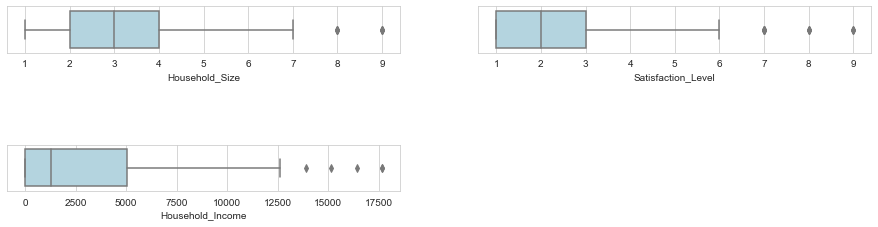

In [246]:
for i in range(1, len(num_cols[1:])+1):
    plt.subplot(9, 2, i)
    sns.boxplot(x=X_test[num_cols[i]], data=X_test[num_cols[i]], color='lightblue')
    
plt.subplots_adjust(top=5, bottom=1, left=1, right=3, hspace=2)
plt.show()

In [247]:
#clip_outliers(X_test, ['Household_Size', 'Household_Income', 'Satisfaction_Level'])

In [248]:
percentile_capping(X_test, ['Household_Size',  'Satisfaction_Level'], 0, 0.02)
percentile_capping(X_test, ['Household_Income'], 0, 0.03)

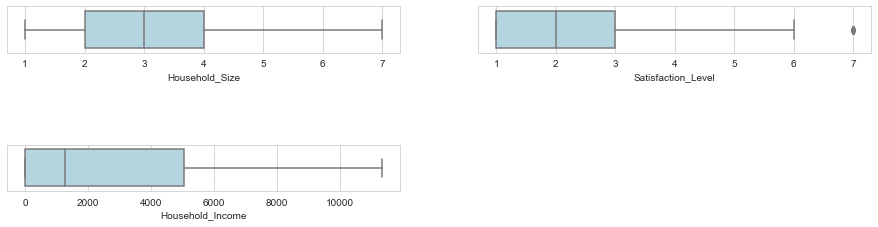

In [249]:
for i in range(1, len(num_cols[1:])+1):
    plt.subplot(9, 2, i)
    sns.boxplot(x=X_test[num_cols[i]], data=X_test[num_cols[i]], color='lightblue')
    
plt.subplots_adjust(top=5, bottom=1, left=1, right=3, hspace=2)
plt.show()

In [250]:
# Feature Scaling
X_test = pd.DataFrame(
    minmax.fit_transform(X_test),
    columns=X_test.columns,
    index=X_test.index)

In [251]:
X_test = X_test[final_selected_features]

In [252]:
# Overview of the test data treated
X_test

,Age,Household_Size,Satisfaction_Level,Household_Income,Gender_Male,Foreign_Citizenship_Yes,Frequent_Traveler_Yes,Cellphone_Usage_High,Cellphone_Usage_Low,Occupation_Private company,Occupation_Student,Political_Participation_Some involvement,Political_Participation_Strong involvement,Political_Participation_Unknown,Social_Person_Yes,Area_Residence_Country-side
ID_ORIGINAL,,,,,,,,,,,,,,,,
460139,0.114286,0.833333,0.000000,0.666667,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
460648,0.157143,0.000000,0.333333,0.888889,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
460835,0.142857,0.000000,0.333333,0.000000,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
461613,0.100000,0.500000,0.000000,0.888889,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
461721,0.114286,0.666667,0.000000,0.777778,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473596,0.228571,0.666667,0.000000,0.111111,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
477769,0.628571,0.166667,0.500000,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475292,0.414286,0.333333,0.166667,0.555556,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


###### Decision Tree Test Results

In [253]:
#y_test_pred_modelDT = modelDT.predict(X_test)
#
#modelDT_test_result = pd.DataFrame(y_test_pred_modelDT, index=X_test.index)
#
#modelDT_test_result.reset_index(inplace=True)
#modelDT_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelDT_test_result

<font color='#4E11A8'><b>Decision Tree best F1 Score on Kaggle:</b></font>

In [254]:
#modelDT_test_result.to_csv(r'data/test-results/DecisionTree_test_result.csv', sep=',', encoding='utf-8', index=False)

###### Bagging Decision Tree Test Results

In [255]:
#y_test_pred_modelBDT = modelBDT.predict(X_test)
#
#modelBDT_test_result = pd.DataFrame(y_test_pred_modelBDT, index=X_test.index)
#
#modelBDT_test_result.reset_index(inplace=True)
#modelBDT_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelBDT_test_result

<font color='#4E11A8'><b>Bagging Decision Tree best F1 Score on Kaggle:</b></font> 0.70050

In [256]:
#modelBDT_test_result.to_csv(r'data/test-results/BaggingDecisionTree_test_result.csv', sep=',', encoding='utf-8', index=False)

###### Gradient Booster Test Results

In [257]:
#y_test_pred_modelGB = modelGB.predict(X_test)
#
#modelGB_test_result = pd.DataFrame(y_test_pred_modelGB, index=X_test.index)
#
#modelGB_test_result.reset_index(inplace=True)
#modelGB_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelGB_test_result

<font color='#4E11A8'><b>Gradient Booster best F1 Score on Kaggle:</b></font> 0.72335

In [258]:
#modelGB_test_result.to_csv(r'data/test-results/GradientBooster_test_result.csv', sep=',', encoding='utf-8', index=False)

###### Grid Search Gradient Booster Test Results

In [259]:
#y_test_pred_modelGSGB = modelGSGB.predict(X_test)
#
#modelGSGB_test_result = pd.DataFrame(y_test_pred_modelGSGB, index=X_test.index)
#
#modelGSGB_test_result.reset_index(inplace=True)
#modelGSGB_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelGSGB_test_result

<font color='#4E11A8'><b>Grid Search Gradient Booster best F1 Score on Kaggle:</b></font> 0.70812

In [260]:
#modelGSGB_test_result.to_csv(r'data/test-results/GS_GradientBooster_test_result.csv', sep=',', encoding='utf-8', index=False)

###### SVC Test Results

In [261]:
#y_test_pred_modelSVC = modelSVC.predict(X_test)
#
#modelSVC_test_result = pd.DataFrame(y_test_pred_modelSVC, index=X_test.index)
#
#modelSVC_test_result.reset_index(inplace=True)
#modelSVC_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelSVC_test_result

<font color='#4E11A8'><b>SVC current F1 best on Kaggle:</b></font> 0.67512

In [262]:
#modelSVC_test_result.to_csv(r'data/test-results/SVC_test_result.csv', sep=',', encoding='utf-8', index=False)

###### Grid Search Random Forest Test Results

In [263]:
#y_test_pred_modelGSRF = modelGSRF.predict(X_test)
#
#modelGSRF_test_result = pd.DataFrame(y_test_pred_modelGSRF, index=X_test.index)
#
#modelGSRF_test_result.reset_index(inplace=True)
#modelGSRF_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelGSRF_test_result

<font color='#4E11A8'><b>Grid Search Random Forest best F1 Score on Kaggle:</b></font> 0.72335

In [264]:
#modelGSRF_test_result.to_csv(r'data/test-results/GS_RandomForest_test_result.csv', sep=',', encoding='utf-8', index=False)

###### MLP Test Results

In [265]:
#y_test_pred_modelMLP = modelMLP.predict(X_test)
#
#modelMLP_test_result = pd.DataFrame(y_test_pred_modelMLP, index=X_test.index)
#
#modelMLP_test_result.reset_index(inplace=True)
#modelMLP_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelMLP_test_result

<font color='#4E11A8'><b>MLP best F1 Score on Kaggle:</b></font> 0.68781

In [266]:
#modelMLP_test_result.to_csv(r'data/test-results/MLP_test_result.csv', sep=',', encoding='utf-8', index=False)

###### Stacking Test Results

In [267]:
#y_test_pred_modelStack = modelStack.predict(X_test)
#
#modelStack_test_result = pd.DataFrame(y_test_pred_modelStack, index=X_test.index)
#
#modelStack_test_result.reset_index(inplace=True)
#modelStack_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelStack_test_result

<font color='#4E11A8'><b>Stacking best F1 Score on Kaggle:</b></font> 0.71827

In [268]:
#modelStack_test_result.to_csv(r'data/test-results/Stacking_test_result.csv', sep=',', encoding='utf-8', index=False)

###### Grid Search AdaBoost Test Results

In [269]:
#y_test_pred_modelGSAB = modelGSAB.predict(X_test)
#
#modelGSAB_test_result = pd.DataFrame(y_test_pred_modelGSAB, index=X_test.index)
#
#modelGSAB_test_result.reset_index(inplace=True)
#modelGSAB_test_result.rename(columns={'index':'ID_ORIGINAL', 0:'Spy'}, inplace=True)
#
#modelGSAB_test_result

<font color='#4E11A8'><b>Grid Search AdaBoost best F1 Score on Kaggle:</b></font>

In [270]:
#modelGSAB_test_result.to_csv(r'data/test-results/GS_AdaBoost_test_result.csv', sep=',', encoding='utf-8', index=False)

___________________________________________________________________________________________________________________________